<a href="https://colab.research.google.com/github/AliveBotswana/alivebotswana-eportfolio-msc-ai/blob/main/DeepLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Cell 1: Install required packages (if not already installed in Colab)
!pip install keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 3.2 MB/s eta 0:00:00


In [2]:
# Cell 2: Imports
# We use these comprehensive imports to support the full pipeline:
# - TensorFlow/Keras for model building, training, and preprocessing
# - NumPy and Matplotlib for data handling and basic visualization
# - Scikit-learn for data splitting and evaluation metrics
# - Seaborn for enhanced visualizations like heatmaps
# - Keras Tuner for hyperparameter optimization
# - OS and Shutil for file management during tuning
# This aligns with best practices for a complete deep learning workflow in image classification,
# allowing us to choose and evaluate architectures, activation functions, etc., as per the key takeaways.
import tensorflow as tf
from tensorflow.keras import layers, models, applications
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import itertools
import keras_tuner as kt
import os
import shutil
%matplotlib inline

In [3]:
# Cell 3: Define class names and load/prepare dataset
# Dataset: CIFAR-10, a standard for image classification, similar to ImageNet mentioned in the notes.
# We split into training, validation, and test sets as emphasized – crucial for evaluating model performance.
# Normalization and one-hot encoding prepare data for the model.
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

# Load and prepare CIFAR-10 dataset
(x_train_full, y_train_full), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

# Normalize pixel values to [0, 1]
x_train_full = x_train_full.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# Convert labels to one-hot encoding
y_train_full = to_categorical(y_train_full, 10)
y_test = to_categorical(y_test, 10)

# Split training data into train and validation sets (80/20 split, stratified)
# This follows good practices for dataset splitting, depending on size (here, 50k training images).
x_train, x_val, y_train, y_val = train_test_split(
    x_train_full, y_train_full, test_size=0.2, random_state=42, stratify=y_train_full
)

print(f"Training: {x_train.shape}, Validation: {x_val.shape}, Test: {x_test.shape}")

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
Training: (40000, 32, 32, 3), Validation: (10000, 32, 32, 3), Test: (10000, 32, 32, 3)


In [4]:
# Cell 4: Data augmentation and generators
# Data augmentation helps improve generalization, a common practice for image recognition tasks.
train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    zoom_range=0.1,
    shear_range=0.1,
    fill_mode='nearest'
)

# No augmentation for validation
val_datagen = ImageDataGenerator()

# Create data generators
# Batch size: 128, chosen as a balance for efficiency (as per notes on choosing batch size).
train_generator = train_datagen.flow(x_train, y_train, batch_size=128)
val_generator = val_datagen.flow(x_val, y_val, batch_size=128)

In [5]:
# Cell 5: Define custom CNN model
# Architecture: Custom deep CNN, chosen after research for image classification.
# Uses ReLU activation as suggested in notes (preferred over Sigmoid for deep networks to avoid vanishing gradients).
# Weights are initialized automatically and updated via backpropagation during training.
def create_custom_cnn():
    """
    Create a custom deep Convolutional Neural Network (CNN) for CIFAR-10 classification.
    The architecture includes multiple convolutional blocks with batch normalization,
    max pooling, and dropout for regularization.
    """
    model = models.Sequential([
        # First Convolutional Block
        layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(32, 32, 3)),
        layers.BatchNormalization(),
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),

        # Second Convolutional Block
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),

        # Third Convolutional Block
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),

        # Fourth Convolutional Block
        layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.GlobalAveragePooling2D(),
        layers.Dropout(0.5),

        # Dense Layers
        layers.Dense(512, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(256, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(10, activation='softmax')
    ])

    return model

In [6]:
# Cell 6: Define transfer learning model
# Transfer learning architecture: ResNet50 (one of the most famous, as per notes), pre-trained on ImageNet.
# Chosen based on research for object recognition/image classification tasks like CIFAR-10.
# Base model frozen, custom layers added for adaptation.
def create_transfer_model():
    """
    Create a transfer learning model using pre-trained ResNet50 as the base.
    The base model is frozen, and custom dense layers are added for classification.
    """
    base_model = applications.ResNet50(weights='imagenet', include_top=False, input_shape=(32, 32, 3))
    base_model.trainable = False  # Freeze base model weights

    model = models.Sequential([
        base_model,
        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(256, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(10, activation='softmax')
    ])

    return model

In [7]:
# Cell 7: Define compile and train function
# Loss function: Categorical crossentropy (standard for multi-class classification).
# Optimizer: Adam with learning rate 0.001 (chosen as per common practices).
# Epochs: Up to 100, with early stopping.
# These are user-chosen hyperparameters as highlighted in the notes.
def compile_and_train_model(model, model_name, use_generator=True):
    """
    Compile and train the model with Adam optimizer, early stopping, learning rate reduction,
    and model checkpointing.
    """
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    callbacks = [
        EarlyStopping(monitor='val_accuracy', patience=15, restore_best_weights=True, verbose=1),
        ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=10, min_lr=1e-7, verbose=1),
        ModelCheckpoint(f'best_{model_name}.h5', monitor='val_accuracy', save_best_only=True, verbose=1)
    ]

    epochs = 100
    batch_size = 128

    if use_generator:
        history = model.fit(
            train_generator,
            epochs=epochs,
            validation_data=val_generator,
            callbacks=callbacks,
            verbose=1
        )
    else:
        history = model.fit(
            x_train, y_train,
            batch_size=batch_size,
            epochs=epochs,
            validation_data=(x_val, y_val),
            callbacks=callbacks,
            verbose=1
        )

    return history, model

In [8]:
# Cell 8: Create and train custom CNN (Run this cell to train; it may take time)
# Training process: Backpropagation updates weights automatically.
custom_cnn = create_custom_cnn()
custom_cnn.summary()
print("Training Custom Deep CNN...")
history_custom, trained_custom = compile_and_train_model(custom_cnn, "custom_cnn")

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 8, 8, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 4, 4, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 4, 4, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 4, 4, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 1,444,650 (5.51 MB)

 Trainable params: 1,441,194 (5.50 MB)

 Non-trainable params: 3,456 (13.50 KB)

Training Custom Deep CNN...


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 0.2343 - loss: 2.5303
Epoch 1: val_accuracy improved from -inf to 0.11140, saving model to best_custom_cnn.h5


313/313 ━━━━━━━━━━━━━━━━━━━━ 59s 129ms/step - accuracy: 0.2345 - loss: 2.5290 - val_accuracy: 0.1114 - val_loss: 6.5140 - learning_rate: 0.0010
Epoch 2/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.4427 - loss: 1.5568
Epoch 2: val_accuracy improved from 0.11140 to 0.56830, saving model to best_custom_cnn.h5


313/313 ━━━━━━━━━━━━━━━━━━━━ 26s 84ms/step - accuracy: 0.4428 - loss: 1.5565 - val_accuracy: 0.5683 - val_loss: 1.2637 - learning_rate: 0.0010
Epoch 3/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.5528 - loss: 1.2655
Epoch 3: val_accuracy improved from 0.56830 to 0.59940, saving model to best_custom_cnn.h5


313/313 ━━━━━━━━━━━━━━━━━━━━ 27s 88ms/step - accuracy: 0.5529 - loss: 1.2654 - val_accuracy: 0.5994 - val_loss: 1.1850 - learning_rate: 0.0010
Epoch 4/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 0.6117 - loss: 1.1089
Epoch 4: val_accuracy improved from 0.59940 to 0.62270, saving model to best_custom_cnn.h5


313/313 ━━━━━━━━━━━━━━━━━━━━ 29s 93ms/step - accuracy: 0.6117 - loss: 1.1089 - val_accuracy: 0.6227 - val_loss: 1.1159 - learning_rate: 0.0010
Epoch 5/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.6524 - loss: 1.0088
Epoch 5: val_accuracy improved from 0.62270 to 0.68000, saving model to best_custom_cnn.h5


313/313 ━━━━━━━━━━━━━━━━━━━━ 25s 81ms/step - accuracy: 0.6524 - loss: 1.0088 - val_accuracy: 0.6800 - val_loss: 0.9859 - learning_rate: 0.0010
Epoch 6/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.6821 - loss: 0.9310
Epoch 6: val_accuracy improved from 0.68000 to 0.72130, saving model to best_custom_cnn.h5


313/313 ━━━━━━━━━━━━━━━━━━━━ 26s 82ms/step - accuracy: 0.6821 - loss: 0.9310 - val_accuracy: 0.7213 - val_loss: 0.8115 - learning_rate: 0.0010
Epoch 7/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.7101 - loss: 0.8509
Epoch 7: val_accuracy did not improve from 0.72130
313/313 ━━━━━━━━━━━━━━━━━━━━ 26s 82ms/step - accuracy: 0.7101 - loss: 0.8509 - val_accuracy: 0.7051 - val_loss: 0.9152 - learning_rate: 0.0010
Epoch 8/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.7276 - loss: 0.8128
Epoch 8: val_accuracy did not improve from 0.72130
313/313 ━━━━━━━━━━━━━━━━━━━━ 26s 82ms/step - accuracy: 0.7276 - loss: 0.8127 - val_accuracy: 0.6961 - val_loss: 1.0449 - learning_rate: 0.0010
Epoch 9/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.7431 - loss: 0.7629
Epoch 9: val_accuracy improved from 0.72130 to 0.72820, saving model to best_custom_cnn.h5


313/313 ━━━━━━━━━━━━━━━━━━━━ 26s 82ms/step - accuracy: 0.7431 - loss: 0.7629 - val_accuracy: 0.7282 - val_loss: 0.8526 - learning_rate: 0.0010
Epoch 10/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.7492 - loss: 0.7470
Epoch 10: val_accuracy improved from 0.72820 to 0.75230, saving model to best_custom_cnn.h5


313/313 ━━━━━━━━━━━━━━━━━━━━ 26s 82ms/step - accuracy: 0.7493 - loss: 0.7470 - val_accuracy: 0.7523 - val_loss: 0.7660 - learning_rate: 0.0010
Epoch 11/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.7626 - loss: 0.7092
Epoch 11: val_accuracy improved from 0.75230 to 0.78090, saving model to best_custom_cnn.h5


313/313 ━━━━━━━━━━━━━━━━━━━━ 26s 82ms/step - accuracy: 0.7626 - loss: 0.7092 - val_accuracy: 0.7809 - val_loss: 0.6708 - learning_rate: 0.0010
Epoch 12/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.7666 - loss: 0.6925
Epoch 12: val_accuracy did not improve from 0.78090
313/313 ━━━━━━━━━━━━━━━━━━━━ 26s 82ms/step - accuracy: 0.7666 - loss: 0.6925 - val_accuracy: 0.7455 - val_loss: 0.7954 - learning_rate: 0.0010
Epoch 13/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.7790 - loss: 0.6559
Epoch 13: val_accuracy improved from 0.78090 to 0.79160, saving model to best_custom_cnn.h5


313/313 ━━━━━━━━━━━━━━━━━━━━ 26s 84ms/step - accuracy: 0.7790 - loss: 0.6559 - val_accuracy: 0.7916 - val_loss: 0.6179 - learning_rate: 0.0010
Epoch 14/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.7846 - loss: 0.6464
Epoch 14: val_accuracy did not improve from 0.79160
313/313 ━━━━━━━━━━━━━━━━━━━━ 26s 84ms/step - accuracy: 0.7846 - loss: 0.6464 - val_accuracy: 0.7807 - val_loss: 0.6952 - learning_rate: 0.0010
Epoch 15/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.7912 - loss: 0.6214
Epoch 15: val_accuracy did not improve from 0.79160
313/313 ━━━━━━━━━━━━━━━━━━━━ 26s 82ms/step - accuracy: 0.7912 - loss: 0.6214 - val_accuracy: 0.7527 - val_loss: 0.7821 - learning_rate: 0.0010
Epoch 16/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.7982 - loss: 0.6128
Epoch 16: val_accuracy improved from 0.79160 to 0.79810, saving model to best_custom_cnn.h5


313/313 ━━━━━━━━━━━━━━━━━━━━ 26s 82ms/step - accuracy: 0.7982 - loss: 0.6128 - val_accuracy: 0.7981 - val_loss: 0.6545 - learning_rate: 0.0010
Epoch 17/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.8009 - loss: 0.5942
Epoch 17: val_accuracy improved from 0.79810 to 0.81070, saving model to best_custom_cnn.h5


313/313 ━━━━━━━━━━━━━━━━━━━━ 26s 83ms/step - accuracy: 0.8009 - loss: 0.5943 - val_accuracy: 0.8107 - val_loss: 0.5722 - learning_rate: 0.0010
Epoch 18/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.8039 - loss: 0.5842
Epoch 18: val_accuracy did not improve from 0.81070
313/313 ━━━━━━━━━━━━━━━━━━━━ 25s 81ms/step - accuracy: 0.8039 - loss: 0.5842 - val_accuracy: 0.7603 - val_loss: 0.7834 - learning_rate: 0.0010
Epoch 19/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.8117 - loss: 0.5596
Epoch 19: val_accuracy improved from 0.81070 to 0.83130, saving model to best_custom_cnn.h5


313/313 ━━━━━━━━━━━━━━━━━━━━ 26s 82ms/step - accuracy: 0.8117 - loss: 0.5596 - val_accuracy: 0.8313 - val_loss: 0.5045 - learning_rate: 0.0010
Epoch 20/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.8129 - loss: 0.5470
Epoch 20: val_accuracy did not improve from 0.83130
313/313 ━━━━━━━━━━━━━━━━━━━━ 26s 83ms/step - accuracy: 0.8129 - loss: 0.5470 - val_accuracy: 0.7924 - val_loss: 0.6322 - learning_rate: 0.0010
Epoch 21/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.8177 - loss: 0.5446
Epoch 21: val_accuracy did not improve from 0.83130
313/313 ━━━━━━━━━━━━━━━━━━━━ 26s 84ms/step - accuracy: 0.8176 - loss: 0.5447 - val_accuracy: 0.8125 - val_loss: 0.5850 - learning_rate: 0.0010
Epoch 22/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.8198 - loss: 0.5362
Epoch 22: val_accuracy did not improve from 0.83130
313/313 ━━━━━━━━━━━━━━━━━━━━ 27s 86ms/step - accuracy: 0.8197 - loss: 0.5362 - val_accuracy: 0.7926 - val_loss: 0.6383 - learning_rate: 0.0010
Epoch

313/313 ━━━━━━━━━━━━━━━━━━━━ 40s 84ms/step - accuracy: 0.8226 - loss: 0.5319 - val_accuracy: 0.8353 - val_loss: 0.4906 - learning_rate: 0.0010
Epoch 24/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.8244 - loss: 0.5130
Epoch 24: val_accuracy improved from 0.83530 to 0.84090, saving model to best_custom_cnn.h5


313/313 ━━━━━━━━━━━━━━━━━━━━ 26s 83ms/step - accuracy: 0.8244 - loss: 0.5130 - val_accuracy: 0.8409 - val_loss: 0.4814 - learning_rate: 0.0010
Epoch 25/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.8340 - loss: 0.4940
Epoch 25: val_accuracy improved from 0.84090 to 0.84120, saving model to best_custom_cnn.h5


313/313 ━━━━━━━━━━━━━━━━━━━━ 26s 84ms/step - accuracy: 0.8339 - loss: 0.4940 - val_accuracy: 0.8412 - val_loss: 0.4712 - learning_rate: 0.0010
Epoch 26/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.8298 - loss: 0.5064
Epoch 26: val_accuracy improved from 0.84120 to 0.84440, saving model to best_custom_cnn.h5


313/313 ━━━━━━━━━━━━━━━━━━━━ 26s 82ms/step - accuracy: 0.8299 - loss: 0.5064 - val_accuracy: 0.8444 - val_loss: 0.4720 - learning_rate: 0.0010
Epoch 27/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.8382 - loss: 0.4765
Epoch 27: val_accuracy did not improve from 0.84440
313/313 ━━━━━━━━━━━━━━━━━━━━ 26s 82ms/step - accuracy: 0.8382 - loss: 0.4766 - val_accuracy: 0.8279 - val_loss: 0.5306 - learning_rate: 0.0010
Epoch 28/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.8387 - loss: 0.4787
Epoch 28: val_accuracy did not improve from 0.84440
313/313 ━━━━━━━━━━━━━━━━━━━━ 26s 84ms/step - accuracy: 0.8387 - loss: 0.4787 - val_accuracy: 0.7930 - val_loss: 0.6568 - learning_rate: 0.0010
Epoch 29/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.8374 - loss: 0.4819
Epoch 29: val_accuracy did not improve from 0.84440
313/313 ━━━━━━━━━━━━━━━━━━━━ 26s 83ms/step - accuracy: 0.8374 - loss: 0.4819 - val_accuracy: 0.8113 - val_loss: 0.5875 - learning_rate: 0.0010
Epoch

313/313 ━━━━━━━━━━━━━━━━━━━━ 26s 83ms/step - accuracy: 0.8452 - loss: 0.4575 - val_accuracy: 0.8452 - val_loss: 0.4622 - learning_rate: 0.0010
Epoch 31/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.8377 - loss: 0.4753
Epoch 31: val_accuracy improved from 0.84520 to 0.85480, saving model to best_custom_cnn.h5


313/313 ━━━━━━━━━━━━━━━━━━━━ 26s 82ms/step - accuracy: 0.8377 - loss: 0.4753 - val_accuracy: 0.8548 - val_loss: 0.4398 - learning_rate: 0.0010
Epoch 32/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.8490 - loss: 0.4582
Epoch 32: val_accuracy did not improve from 0.85480
313/313 ━━━━━━━━━━━━━━━━━━━━ 26s 82ms/step - accuracy: 0.8490 - loss: 0.4582 - val_accuracy: 0.8294 - val_loss: 0.5363 - learning_rate: 0.0010
Epoch 33/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.8508 - loss: 0.4424
Epoch 33: val_accuracy did not improve from 0.85480
313/313 ━━━━━━━━━━━━━━━━━━━━ 26s 82ms/step - accuracy: 0.8508 - loss: 0.4424 - val_accuracy: 0.8426 - val_loss: 0.4841 - learning_rate: 0.0010
Epoch 34/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.8474 - loss: 0.4484
Epoch 34: val_accuracy did not improve from 0.85480
313/313 ━━━━━━━━━━━━━━━━━━━━ 26s 82ms/step - accuracy: 0.8474 - loss: 0.4484 - val_accuracy: 0.8300 - val_loss: 0.5295 - learning_rate: 0.0010
Epoch

313/313 ━━━━━━━━━━━━━━━━━━━━ 26s 83ms/step - accuracy: 0.8561 - loss: 0.4332 - val_accuracy: 0.8609 - val_loss: 0.4240 - learning_rate: 0.0010
Epoch 36/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.8541 - loss: 0.4315
Epoch 36: val_accuracy did not improve from 0.86090
313/313 ━━━━━━━━━━━━━━━━━━━━ 26s 83ms/step - accuracy: 0.8541 - loss: 0.4315 - val_accuracy: 0.8279 - val_loss: 0.5325 - learning_rate: 0.0010
Epoch 37/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.8550 - loss: 0.4294
Epoch 37: val_accuracy did not improve from 0.86090
313/313 ━━━━━━━━━━━━━━━━━━━━ 27s 85ms/step - accuracy: 0.8550 - loss: 0.4295 - val_accuracy: 0.8567 - val_loss: 0.4447 - learning_rate: 0.0010
Epoch 38/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.8580 - loss: 0.4163
Epoch 38: val_accuracy did not improve from 0.86090
313/313 ━━━━━━━━━━━━━━━━━━━━ 26s 82ms/step - accuracy: 0.8580 - loss: 0.4163 - val_accuracy: 0.8541 - val_loss: 0.4574 - learning_rate: 0.0010
Epoch

313/313 ━━━━━━━━━━━━━━━━━━━━ 26s 82ms/step - accuracy: 0.8595 - loss: 0.4151 - val_accuracy: 0.8732 - val_loss: 0.3809 - learning_rate: 0.0010
Epoch 40/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.8620 - loss: 0.4044
Epoch 40: val_accuracy did not improve from 0.87320
313/313 ━━━━━━━━━━━━━━━━━━━━ 26s 85ms/step - accuracy: 0.8620 - loss: 0.4044 - val_accuracy: 0.8154 - val_loss: 0.5980 - learning_rate: 0.0010
Epoch 41/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.8621 - loss: 0.4090
Epoch 41: val_accuracy did not improve from 0.87320
313/313 ━━━━━━━━━━━━━━━━━━━━ 26s 84ms/step - accuracy: 0.8621 - loss: 0.4090 - val_accuracy: 0.8624 - val_loss: 0.4295 - learning_rate: 0.0010
Epoch 42/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.8652 - loss: 0.4018
Epoch 42: val_accuracy did not improve from 0.87320
313/313 ━━━━━━━━━━━━━━━━━━━━ 26s 82ms/step - accuracy: 0.8652 - loss: 0.4018 - val_accuracy: 0.8618 - val_loss: 0.4315 - learning_rate: 0.0010
Epoch

313/313 ━━━━━━━━━━━━━━━━━━━━ 26s 83ms/step - accuracy: 0.8816 - loss: 0.3427 - val_accuracy: 0.8814 - val_loss: 0.3764 - learning_rate: 2.0000e-04
Epoch 51/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.8882 - loss: 0.3246
Epoch 51: val_accuracy did not improve from 0.88140
313/313 ━━━━━━━━━━━━━━━━━━━━ 26s 82ms/step - accuracy: 0.8882 - loss: 0.3246 - val_accuracy: 0.8802 - val_loss: 0.3718 - learning_rate: 2.0000e-04
Epoch 52/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.8961 - loss: 0.3097
Epoch 52: val_accuracy improved from 0.88140 to 0.88790, saving model to best_custom_cnn.h5


313/313 ━━━━━━━━━━━━━━━━━━━━ 27s 86ms/step - accuracy: 0.8961 - loss: 0.3097 - val_accuracy: 0.8879 - val_loss: 0.3606 - learning_rate: 2.0000e-04
Epoch 53/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.8959 - loss: 0.3097
Epoch 53: val_accuracy did not improve from 0.88790
313/313 ━━━━━━━━━━━━━━━━━━━━ 26s 83ms/step - accuracy: 0.8959 - loss: 0.3097 - val_accuracy: 0.8818 - val_loss: 0.3760 - learning_rate: 2.0000e-04
Epoch 54/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.8940 - loss: 0.3139
Epoch 54: val_accuracy improved from 0.88790 to 0.88830, saving model to best_custom_cnn.h5


313/313 ━━━━━━━━━━━━━━━━━━━━ 26s 83ms/step - accuracy: 0.8940 - loss: 0.3139 - val_accuracy: 0.8883 - val_loss: 0.3472 - learning_rate: 2.0000e-04
Epoch 55/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.8979 - loss: 0.2993
Epoch 55: val_accuracy did not improve from 0.88830
313/313 ━━━━━━━━━━━━━━━━━━━━ 26s 82ms/step - accuracy: 0.8979 - loss: 0.2993 - val_accuracy: 0.8830 - val_loss: 0.3573 - learning_rate: 2.0000e-04
Epoch 56/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.8992 - loss: 0.2975
Epoch 56: val_accuracy did not improve from 0.88830
313/313 ━━━━━━━━━━━━━━━━━━━━ 26s 83ms/step - accuracy: 0.8992 - loss: 0.2975 - val_accuracy: 0.8863 - val_loss: 0.3570 - learning_rate: 2.0000e-04
Epoch 57/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.8992 - loss: 0.2955
Epoch 57: val_accuracy did not improve from 0.88830
313/313 ━━━━━━━━━━━━━━━━━━━━ 26s 82ms/step - accuracy: 0.8992 - loss: 0.2955 - val_accuracy: 0.8845 - val_loss: 0.3720 - learning_rate: 

313/313 ━━━━━━━━━━━━━━━━━━━━ 26s 83ms/step - accuracy: 0.9025 - loss: 0.2828 - val_accuracy: 0.8887 - val_loss: 0.3473 - learning_rate: 2.0000e-04
Epoch 60/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.9018 - loss: 0.2896
Epoch 60: val_accuracy did not improve from 0.88870
313/313 ━━━━━━━━━━━━━━━━━━━━ 27s 87ms/step - accuracy: 0.9018 - loss: 0.2896 - val_accuracy: 0.8761 - val_loss: 0.3902 - learning_rate: 2.0000e-04
Epoch 61/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.9020 - loss: 0.2833
Epoch 61: val_accuracy did not improve from 0.88870
313/313 ━━━━━━━━━━━━━━━━━━━━ 27s 85ms/step - accuracy: 0.9020 - loss: 0.2833 - val_accuracy: 0.8861 - val_loss: 0.3578 - learning_rate: 2.0000e-04
Epoch 62/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.9034 - loss: 0.2789
Epoch 62: val_accuracy did not improve from 0.88870
313/313 ━━━━━━━━━━━━━━━━━━━━ 26s 84ms/step - accuracy: 0.9034 - loss: 0.2790 - val_accuracy: 0.8839 - val_loss: 0.3615 - learning_rate: 

313/313 ━━━━━━━━━━━━━━━━━━━━ 26s 83ms/step - accuracy: 0.9097 - loss: 0.2661 - val_accuracy: 0.8892 - val_loss: 0.3465 - learning_rate: 4.0000e-05
Epoch 70/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.9069 - loss: 0.2720
Epoch 70: val_accuracy improved from 0.88920 to 0.89130, saving model to best_custom_cnn.h5


313/313 ━━━━━━━━━━━━━━━━━━━━ 26s 82ms/step - accuracy: 0.9069 - loss: 0.2719 - val_accuracy: 0.8913 - val_loss: 0.3452 - learning_rate: 4.0000e-05
Epoch 71/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.9090 - loss: 0.2653
Epoch 71: val_accuracy did not improve from 0.89130
313/313 ━━━━━━━━━━━━━━━━━━━━ 26s 82ms/step - accuracy: 0.9090 - loss: 0.2653 - val_accuracy: 0.8888 - val_loss: 0.3519 - learning_rate: 4.0000e-05
Epoch 72/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.9125 - loss: 0.2506
Epoch 72: val_accuracy did not improve from 0.89130
313/313 ━━━━━━━━━━━━━━━━━━━━ 26s 83ms/step - accuracy: 0.9125 - loss: 0.2507 - val_accuracy: 0.8887 - val_loss: 0.3534 - learning_rate: 4.0000e-05
Epoch 73/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.9118 - loss: 0.2620
Epoch 73: val_accuracy did not improve from 0.89130
313/313 ━━━━━━━━━━━━━━━━━━━━ 26s 82ms/step - accuracy: 0.9118 - loss: 0.2620 - val_accuracy: 0.8869 - val_loss: 0.3607 - learning_rate: 

In [10]:
# Cell 9: Create and train transfer model (Run this cell to train; it may take time)
transfer_model = create_transfer_model()
transfer_model.summary()
print("Training Transfer Learning Model...")
history_transfer, trained_transfer = compile_and_train_model(transfer_model, "transfer_model")

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 1, 1, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,773,770 (94.50 MB)

 Trainable params: 1,184,522 (4.52 MB)

 Non-trainable params: 23,589,248 (89.99 MB)

Training Transfer Learning Model...
Epoch 1/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - accuracy: 0.2262 - loss: 2.5554
Epoch 1: val_accuracy improved from -inf to 0.24330, saving model to best_transfer_model.h5


313/313 ━━━━━━━━━━━━━━━━━━━━ 50s 122ms/step - accuracy: 0.2263 - loss: 2.5546 - val_accuracy: 0.2433 - val_loss: 2.5187 - learning_rate: 0.0010
Epoch 2/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.3168 - loss: 1.9500
Epoch 2: val_accuracy did not improve from 0.24330
313/313 ━━━━━━━━━━━━━━━━━━━━ 26s 82ms/step - accuracy: 0.3168 - loss: 1.9499 - val_accuracy: 0.1928 - val_loss: 3.6894 - learning_rate: 0.0010
Epoch 3/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.3537 - loss: 1.8146
Epoch 3: val_accuracy did not improve from 0.24330
313/313 ━━━━━━━━━━━━━━━━━━━━ 26s 82ms/step - accuracy: 0.3537 - loss: 1.8145 - val_accuracy: 0.1240 - val_loss: 4.5199 - learning_rate: 0.0010
Epoch 4/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.3647 - loss: 1.7732
Epoch 4: val_accuracy did not improve from 0.24330
313/313 ━━━━━━━━━━━━━━━━━━━━ 25s 81ms/step - accuracy: 0.3647 - loss: 1.7732 - val_accuracy: 0.2184 - val_loss: 2.4945 - learning_rate: 0.0010
Epoch 5/10

313/313 ━━━━━━━━━━━━━━━━━━━━ 26s 82ms/step - accuracy: 0.4091 - loss: 1.6513 - val_accuracy: 0.3032 - val_loss: 2.6451 - learning_rate: 0.0010
Epoch 12/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.4093 - loss: 1.6498
Epoch 12: val_accuracy improved from 0.30320 to 0.32110, saving model to best_transfer_model.h5


313/313 ━━━━━━━━━━━━━━━━━━━━ 26s 82ms/step - accuracy: 0.4093 - loss: 1.6498 - val_accuracy: 0.3211 - val_loss: 1.9755 - learning_rate: 0.0010
Epoch 13/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.4198 - loss: 1.6360
Epoch 13: val_accuracy did not improve from 0.32110
313/313 ━━━━━━━━━━━━━━━━━━━━ 25s 80ms/step - accuracy: 0.4198 - loss: 1.6360 - val_accuracy: 0.2327 - val_loss: 2.8284 - learning_rate: 0.0010
Epoch 14/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.4163 - loss: 1.6472
Epoch 14: val_accuracy did not improve from 0.32110
313/313 ━━━━━━━━━━━━━━━━━━━━ 25s 79ms/step - accuracy: 0.4163 - loss: 1.6471 - val_accuracy: 0.2015 - val_loss: 2.9023 - learning_rate: 0.0010
Epoch 15/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.4192 - loss: 1.6352
Epoch 15: val_accuracy improved from 0.32110 to 0.32790, saving model to best_transfer_model.h5


313/313 ━━━━━━━━━━━━━━━━━━━━ 26s 82ms/step - accuracy: 0.4192 - loss: 1.6352 - val_accuracy: 0.3279 - val_loss: 2.0771 - learning_rate: 0.0010
Epoch 16/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.4169 - loss: 1.6386
Epoch 16: val_accuracy did not improve from 0.32790
313/313 ━━━━━━━━━━━━━━━━━━━━ 25s 80ms/step - accuracy: 0.4169 - loss: 1.6386 - val_accuracy: 0.1414 - val_loss: 4.6172 - learning_rate: 0.0010
Epoch 17/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.4137 - loss: 1.6389
Epoch 17: val_accuracy did not improve from 0.32790
313/313 ━━━━━━━━━━━━━━━━━━━━ 25s 79ms/step - accuracy: 0.4137 - loss: 1.6389 - val_accuracy: 0.2707 - val_loss: 3.0432 - learning_rate: 0.0010
Epoch 18/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.4106 - loss: 1.6458
Epoch 18: val_accuracy did not improve from 0.32790
313/313 ━━━━━━━━━━━━━━━━━━━━ 25s 80ms/step - accuracy: 0.4106 - loss: 1.6458 - val_accuracy: 0.2423 - val_loss: 2.5886 - learning_rate: 0.0010
Epoch

313/313 ━━━━━━━━━━━━━━━━━━━━ 26s 82ms/step - accuracy: 0.4199 - loss: 1.6408 - val_accuracy: 0.3416 - val_loss: 1.9761 - learning_rate: 0.0010
Epoch 20/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.4181 - loss: 1.6217
Epoch 20: val_accuracy did not improve from 0.34160
313/313 ━━━━━━━━━━━━━━━━━━━━ 25s 81ms/step - accuracy: 0.4181 - loss: 1.6217 - val_accuracy: 0.1493 - val_loss: 2.9044 - learning_rate: 0.0010
Epoch 21/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.4230 - loss: 1.6213
Epoch 21: val_accuracy improved from 0.34160 to 0.38100, saving model to best_transfer_model.h5


313/313 ━━━━━━━━━━━━━━━━━━━━ 26s 82ms/step - accuracy: 0.4230 - loss: 1.6213 - val_accuracy: 0.3810 - val_loss: 1.7502 - learning_rate: 0.0010
Epoch 22/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.4244 - loss: 1.6140
Epoch 22: val_accuracy did not improve from 0.38100
313/313 ━━━━━━━━━━━━━━━━━━━━ 26s 81ms/step - accuracy: 0.4244 - loss: 1.6140 - val_accuracy: 0.2219 - val_loss: 4.5584 - learning_rate: 0.0010
Epoch 23/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.4241 - loss: 1.6173
Epoch 23: val_accuracy did not improve from 0.38100
313/313 ━━━━━━━━━━━━━━━━━━━━ 27s 85ms/step - accuracy: 0.4241 - loss: 1.6173 - val_accuracy: 0.2265 - val_loss: 3.0606 - learning_rate: 0.0010
Epoch 24/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.4216 - loss: 1.6196
Epoch 24: val_accuracy did not improve from 0.38100
313/313 ━━━━━━━━━━━━━━━━━━━━ 25s 80ms/step - accuracy: 0.4216 - loss: 1.6196 - val_accuracy: 0.1238 - val_loss: 5.4643 - learning_rate: 0.0010
Epoch

313/313 ━━━━━━━━━━━━━━━━━━━━ 26s 82ms/step - accuracy: 0.4261 - loss: 1.6063 - val_accuracy: 0.3960 - val_loss: 1.8540 - learning_rate: 0.0010
Epoch 27/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.4363 - loss: 1.5973
Epoch 27: val_accuracy did not improve from 0.39600
313/313 ━━━━━━━━━━━━━━━━━━━━ 25s 80ms/step - accuracy: 0.4362 - loss: 1.5974 - val_accuracy: 0.2453 - val_loss: 3.8800 - learning_rate: 0.0010
Epoch 28/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.4300 - loss: 1.6075
Epoch 28: val_accuracy did not improve from 0.39600
313/313 ━━━━━━━━━━━━━━━━━━━━ 25s 80ms/step - accuracy: 0.4300 - loss: 1.6075 - val_accuracy: 0.3168 - val_loss: 2.7564 - learning_rate: 0.0010
Epoch 29/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.4293 - loss: 1.6096
Epoch 29: val_accuracy did not improve from 0.39600
313/313 ━━━━━━━━━━━━━━━━━━━━ 25s 80ms/step - accuracy: 0.4293 - loss: 1.6096 - val_accuracy: 0.2527 - val_loss: 2.6841 - learning_rate: 0.0010
Epoch

313/313 ━━━━━━━━━━━━━━━━━━━━ 26s 83ms/step - accuracy: 0.4337 - loss: 1.5928 - val_accuracy: 0.4533 - val_loss: 1.5165 - learning_rate: 2.0000e-04
Epoch 33/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.4412 - loss: 1.5766
Epoch 33: val_accuracy did not improve from 0.45330
313/313 ━━━━━━━━━━━━━━━━━━━━ 25s 81ms/step - accuracy: 0.4412 - loss: 1.5766 - val_accuracy: 0.4387 - val_loss: 1.5951 - learning_rate: 2.0000e-04
Epoch 34/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.4447 - loss: 1.5675
Epoch 34: val_accuracy did not improve from 0.45330
313/313 ━━━━━━━━━━━━━━━━━━━━ 25s 80ms/step - accuracy: 0.4447 - loss: 1.5675 - val_accuracy: 0.2684 - val_loss: 2.2469 - learning_rate: 2.0000e-04
Epoch 35/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.4497 - loss: 1.5524
Epoch 35: val_accuracy did not improve from 0.45330
313/313 ━━━━━━━━━━━━━━━━━━━━ 25s 80ms/step - accuracy: 0.4497 - loss: 1.5525 - val_accuracy: 0.4074 - val_loss: 1.8153 - learning_rate: 

313/313 ━━━━━━━━━━━━━━━━━━━━ 26s 84ms/step - accuracy: 0.4424 - loss: 1.5701 - val_accuracy: 0.4648 - val_loss: 1.5281 - learning_rate: 2.0000e-04
Epoch 38/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.4496 - loss: 1.5503
Epoch 38: val_accuracy did not improve from 0.46480
313/313 ━━━━━━━━━━━━━━━━━━━━ 25s 80ms/step - accuracy: 0.4496 - loss: 1.5503 - val_accuracy: 0.4228 - val_loss: 1.6090 - learning_rate: 2.0000e-04
Epoch 39/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.4467 - loss: 1.5635
Epoch 39: val_accuracy did not improve from 0.46480
313/313 ━━━━━━━━━━━━━━━━━━━━ 25s 80ms/step - accuracy: 0.4467 - loss: 1.5635 - val_accuracy: 0.3868 - val_loss: 1.7139 - learning_rate: 2.0000e-04
Epoch 40/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.4545 - loss: 1.5501
Epoch 40: val_accuracy did not improve from 0.46480
313/313 ━━━━━━━━━━━━━━━━━━━━ 25s 81ms/step - accuracy: 0.4545 - loss: 1.5501 - val_accuracy: 0.4355 - val_loss: 1.5699 - learning_rate: 

313/313 ━━━━━━━━━━━━━━━━━━━━ 26s 83ms/step - accuracy: 0.4453 - loss: 1.5577 - val_accuracy: 0.4840 - val_loss: 1.4702 - learning_rate: 4.0000e-05
Epoch 44/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.4490 - loss: 1.5542
Epoch 44: val_accuracy did not improve from 0.48400
313/313 ━━━━━━━━━━━━━━━━━━━━ 25s 81ms/step - accuracy: 0.4490 - loss: 1.5542 - val_accuracy: 0.4590 - val_loss: 1.5077 - learning_rate: 4.0000e-05
Epoch 45/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.4508 - loss: 1.5501
Epoch 45: val_accuracy improved from 0.48400 to 0.51110, saving model to best_transfer_model.h5


313/313 ━━━━━━━━━━━━━━━━━━━━ 26s 82ms/step - accuracy: 0.4508 - loss: 1.5501 - val_accuracy: 0.5111 - val_loss: 1.3941 - learning_rate: 4.0000e-05
Epoch 46/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.4517 - loss: 1.5472
Epoch 46: val_accuracy did not improve from 0.51110
313/313 ━━━━━━━━━━━━━━━━━━━━ 25s 81ms/step - accuracy: 0.4517 - loss: 1.5472 - val_accuracy: 0.5087 - val_loss: 1.4062 - learning_rate: 4.0000e-05
Epoch 47/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.4536 - loss: 1.5443
Epoch 47: val_accuracy did not improve from 0.51110
313/313 ━━━━━━━━━━━━━━━━━━━━ 25s 81ms/step - accuracy: 0.4536 - loss: 1.5443 - val_accuracy: 0.5061 - val_loss: 1.3981 - learning_rate: 4.0000e-05
Epoch 48/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.4533 - loss: 1.5485
Epoch 48: val_accuracy did not improve from 0.51110
313/313 ━━━━━━━━━━━━━━━━━━━━ 26s 81ms/step - accuracy: 0.4533 - loss: 1.5485 - val_accuracy: 0.5059 - val_loss: 1.4066 - learning_rate: 

In [11]:
# Cell 10: Define evaluation function
def comprehensive_evaluation(model, model_name, x_test, y_test):
    """
    Evaluate the model on test data, including accuracy, loss, classification report,
    and confusion matrix.
    """
    test_loss, test_accuracy = model.evaluate(x_test, y_test, verbose=0)
    print(f"\n=== {model_name} Evaluation ===")
    print(f"Test Accuracy: {test_accuracy:.4f}")
    print(f"Test Loss: {test_loss:.4f}")

    y_pred = model.predict(x_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true_classes = np.argmax(y_test, axis=1)

    print(f"\nClassification Report for {model_name}:")
    print(classification_report(y_true_classes, y_pred_classes, target_names=class_names))

    cm = confusion_matrix(y_true_classes, y_pred_classes)

    return test_accuracy, y_pred_classes, cm

In [12]:
# Cell 11: Evaluate models
acc_custom, pred_custom, cm_custom = comprehensive_evaluation(trained_custom, "Custom CNN", x_test, y_test)
acc_transfer, pred_transfer, cm_transfer = comprehensive_evaluation(trained_transfer, "Transfer Learning (ResNet50)", x_test, y_test)


=== Custom CNN Evaluation ===
Test Accuracy: 0.8837
Test Loss: 0.3746
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step

Classification Report for Custom CNN:
              precision    recall  f1-score   support

    airplane       0.91      0.89      0.90      1000
  automobile       0.95      0.96      0.95      1000
        bird       0.87      0.83      0.85      1000
         cat       0.84      0.72      0.77      1000
        deer       0.86      0.86      0.86      1000
         dog       0.87      0.78      0.82      1000
        frog       0.80      0.97      0.88      1000
       horse       0.90      0.93      0.92      1000
        ship       0.94      0.93      0.94      1000
       truck       0.89      0.96      0.92      1000

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000


=== Transfer Learning (ResNet50) Evaluation ===
Test Accuracy: 0.5070
Test Loss: 1.3821
3

In [14]:
# Cell 14: Define plot confusion matrix
def plot_confusion_matrix(cm, class_names, model_name):
    """
    Plot the confusion matrix with annotations.
    """
    plt.figure(figsize=(10, 8))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(f'Confusion Matrix - {model_name}')
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()

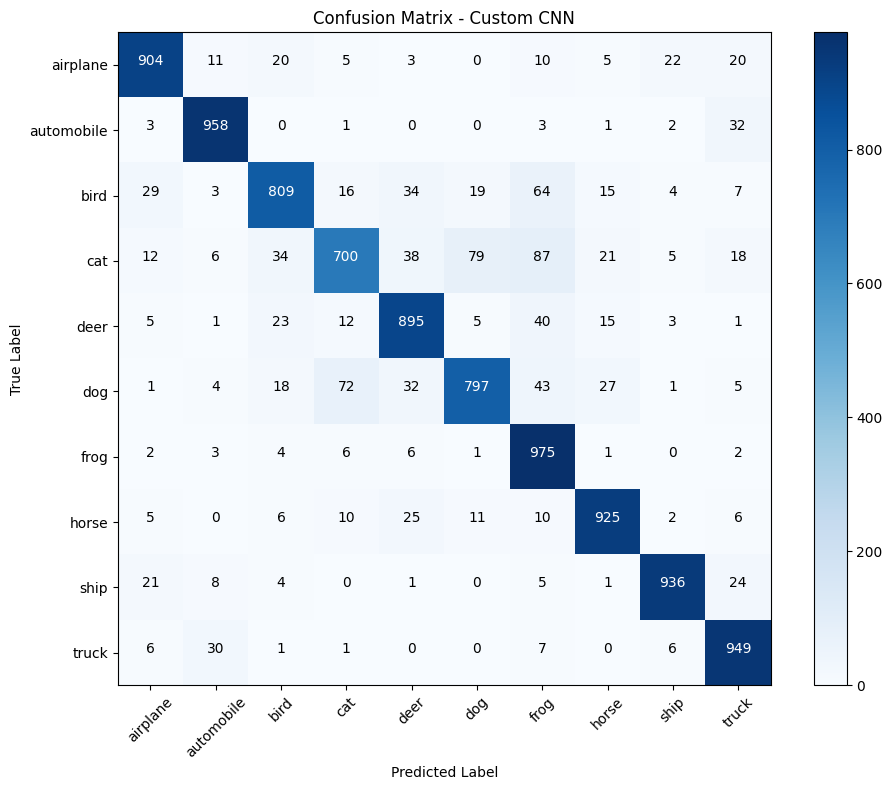

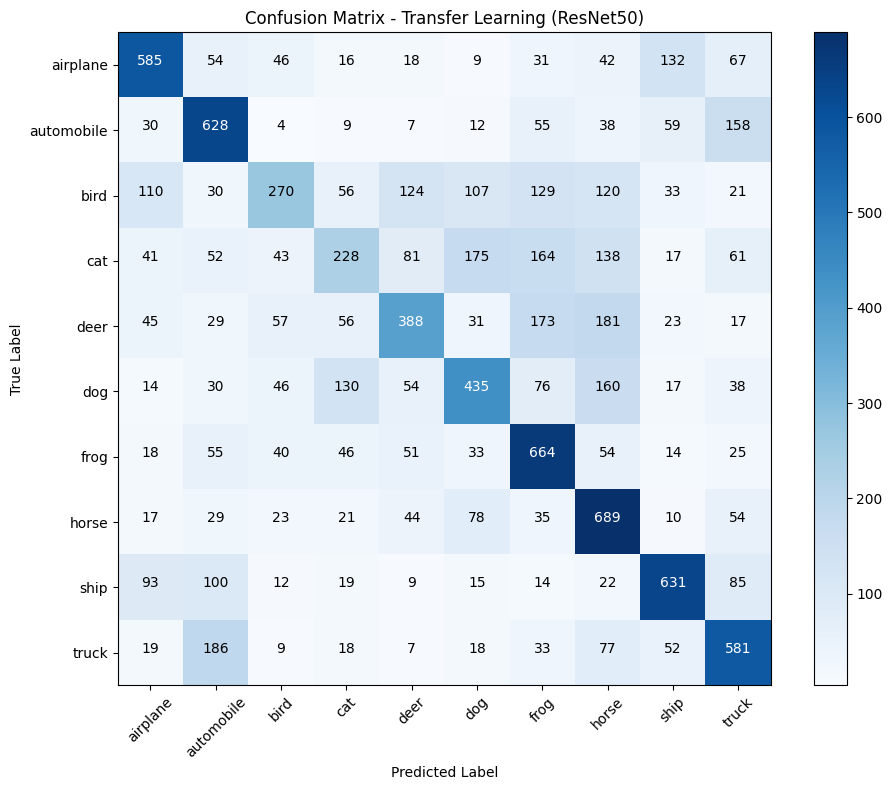

In [ ]:
# Cell 15: Plot confusion matrices
plot_confusion_matrix(cm_custom, class_names, "Custom CNN")
plot_confusion_matrix(cm_transfer, class_names, "Transfer Learning (ResNet50)")

In [15]:
# Cell 16: Define hyperparameter tuning function
# Hyperparameter tuning aligns with choosing optimal settings like layers, filters, learning rate.
def hyperparameter_tuning(x_train, y_train, x_val, y_val, max_trials=5):
    """
    Perform hyperparameter tuning using Keras Tuner RandomSearch.
    """
    print("🚀 Starting Hyperparameter Tuning...")
    print(f"Max trials: {max_trials}")

    def build_model(hp):
        model = models.Sequential()

        # Tune number of convolutional layers
        for i in range(hp.Int('num_conv_layers', 2, 4)):
            model.add(layers.Conv2D(
                hp.Int(f'filters_{i}', 32, 128, step=32),
                (3, 3), activation='relu', padding='same',
                input_shape=(32, 32, 3) if i == 0 else None
            ))
            model.add(layers.BatchNormalization())
            if hp.Boolean(f'maxpool_{i}'):
                model.add(layers.MaxPooling2D((2, 2)))
            model.add(layers.Dropout(hp.Float(f'dropout_{i}', 0.1, 0.4)))

        model.add(layers.GlobalAveragePooling2D())

        # Tune dense layers
        for i in range(hp.Int('num_dense_layers', 1, 2)):
            model.add(layers.Dense(
                hp.Int(f'dense_units_{i}', 128, 512, step=128),
                activation='relu'
            ))
            model.add(layers.Dropout(hp.Float(f'dense_dropout_{i}', 0.2, 0.5)))

        model.add(layers.Dense(10, activation='softmax'))

        # Tune learning rate
        learning_rate = hp.Float('lr', 1e-4, 1e-2, sampling='log')
        model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )

        return model

    # Clear previous tuning directory
    if os.path.exists('tuning'):
        shutil.rmtree('tuning')

    tuner = kt.RandomSearch(
        build_model,
        objective='val_accuracy',
        max_trials=max_trials,
        executions_per_trial=1,
        directory='tuning',
        project_name='cifar10_cnn',
        overwrite=True
    )

    tuner.search_space_summary()

    tuner.search(
        x_train, y_train,
        epochs=20,
        validation_data=(x_val, y_val),
        batch_size=128,
        verbose=1
    )

    best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
    best_model = tuner.get_best_models(num_models=1)[0]

    print("\n🏆 Best Hyperparameters:")
    print(f"Number of Conv Layers: {best_hps.get('num_conv_layers')}")
    print(f"Learning Rate: {best_hps.get('lr'):.6f}")
    for i in range(best_hps.get('num_conv_layers')):
        print(f"Conv Layer {i+1} Filters: {best_hps.get(f'filters_{i}')}")
        print(f"Conv Layer {i+1} Dropout: {best_hps.get(f'dropout_{i}'):.3f}")
    print(f"Number of Dense Layers: {best_hps.get('num_dense_layers')}")
    for i in range(best_hps.get('num_dense_layers')):
        print(f"Dense Layer {i+1} Units: {best_hps.get(f'dense_units_{i}')}")

    # Evaluate best model on validation set
    best_loss, best_accuracy = best_model.evaluate(x_val, y_val, verbose=0)
    print(f"Validation Accuracy: {best_accuracy:.4f}")
    print(f"Validation Loss: {best_loss:.4f}")

    return best_model, best_hps

In [22]:
# Cell 17: Run hyperparameter tuning (Uncomment to run; takes significant time)
best_model, best_hps = hyperparameter_tuning(x_train, y_train, x_val, y_val, max_trials=3)

Trial 3 Complete [00h 01m 08s]
val_accuracy: 0.5859000086784363

Best val_accuracy So Far: 0.7633000016212463
Total elapsed time: 00h 06m 31s


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 46 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))



🏆 Best Hyperparameters:
Number of Conv Layers: 4
Learning Rate: 0.000604
Conv Layer 1 Filters: 128
Conv Layer 1 Dropout: 0.126
Conv Layer 2 Filters: 64
Conv Layer 2 Dropout: 0.268
Conv Layer 3 Filters: 32
Conv Layer 3 Dropout: 0.100
Conv Layer 4 Filters: 32
Conv Layer 4 Dropout: 0.100
Number of Dense Layers: 2
Dense Layer 1 Units: 256
Dense Layer 2 Units: 128
Validation Accuracy: 0.7633
Validation Loss: 0.6760


In [23]:
# Cell to visualize hyperparameter tuning results
# Visualize the performance of each trial during hyperparameter tuning.
# This helps understand which hyperparameter combinations led to better results.
if 'tuner' in locals() and tuner.results_summary():
    results = tuner.results_summary().sort_values('score', ascending=False)
    print("\n📈 Hyperparameter Tuning Results Summary (Sorted by Validation Accuracy):")
    display(results[['trial_id', 'score', 'tuner/epochs', 'tuner/initial_epoch', 'tuner/bracket', 'tuner/round', 'tuner/execution', 'num_conv_layers', 'lr', 'num_dense_layers']])

    # Plotting the results
    plt.figure(figsize=(12, 6))
    plt.plot(results['score'].values, marker='o', linestyle='-')
    plt.title('Hyperparameter Tuning Trials - Validation Accuracy')
    plt.xlabel('Trial Number (Sorted by Accuracy)')
    plt.ylabel('Validation Accuracy')
    plt.grid(True)
    plt.show()
else:
    print("Hyperparameter tuning has not been run yet or tuner object is not available.")

Hyperparameter tuning has not been run yet or tuner object is not available.


Custom CNN Metrics:


/tmp/ipython-input-512510603.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Class', y=metric, data=df, ax=axes[i], palette='Blues_d')
/tmp/ipython-input-512510603.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Class', y=metric, data=df, ax=axes[i], palette='Blues_d')
/tmp/ipython-input-512510603.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Class', y=metric, data=df, ax=axes[i], palette='Blues_d')


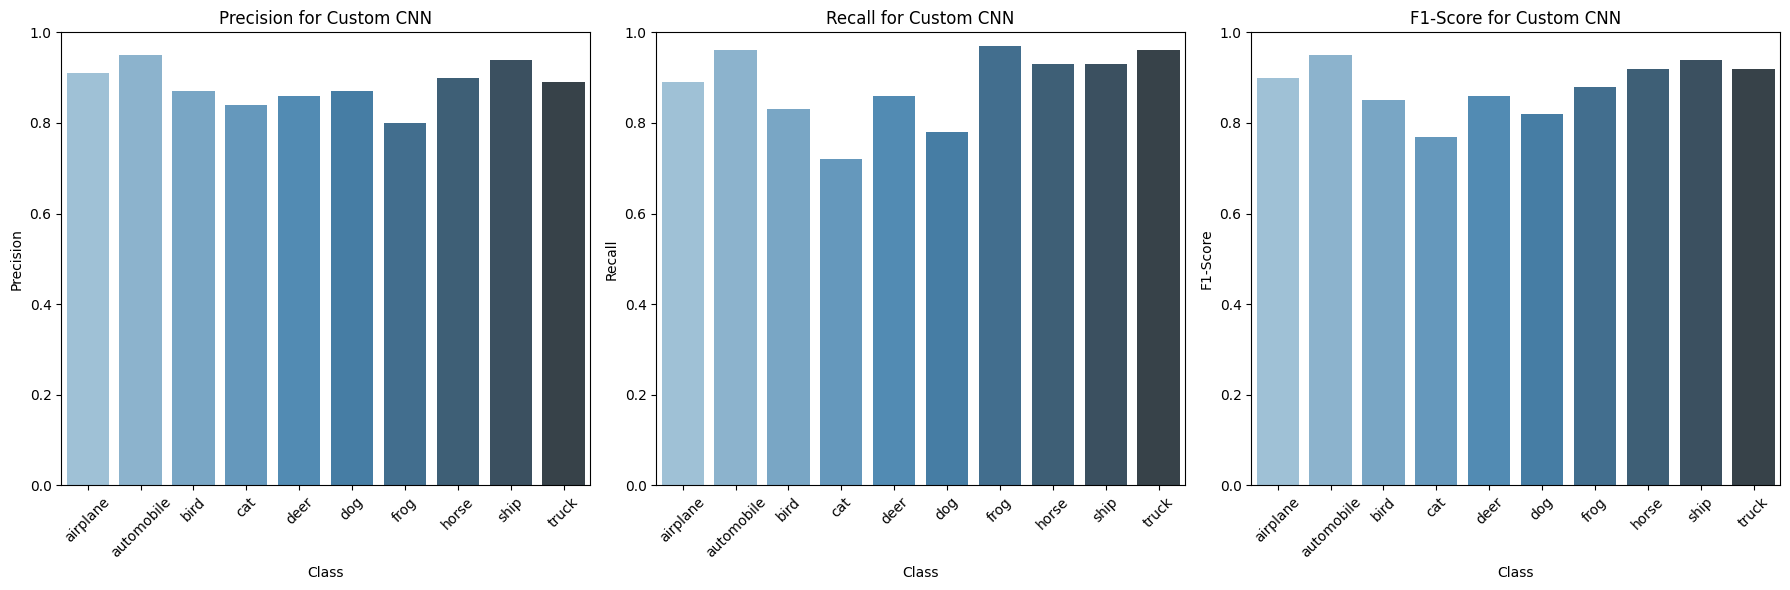

ResNet50 Metrics:


/tmp/ipython-input-512510603.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Class', y=metric, data=df, ax=axes[i], palette='Blues_d')
/tmp/ipython-input-512510603.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Class', y=metric, data=df, ax=axes[i], palette='Blues_d')
/tmp/ipython-input-512510603.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Class', y=metric, data=df, ax=axes[i], palette='Blues_d')


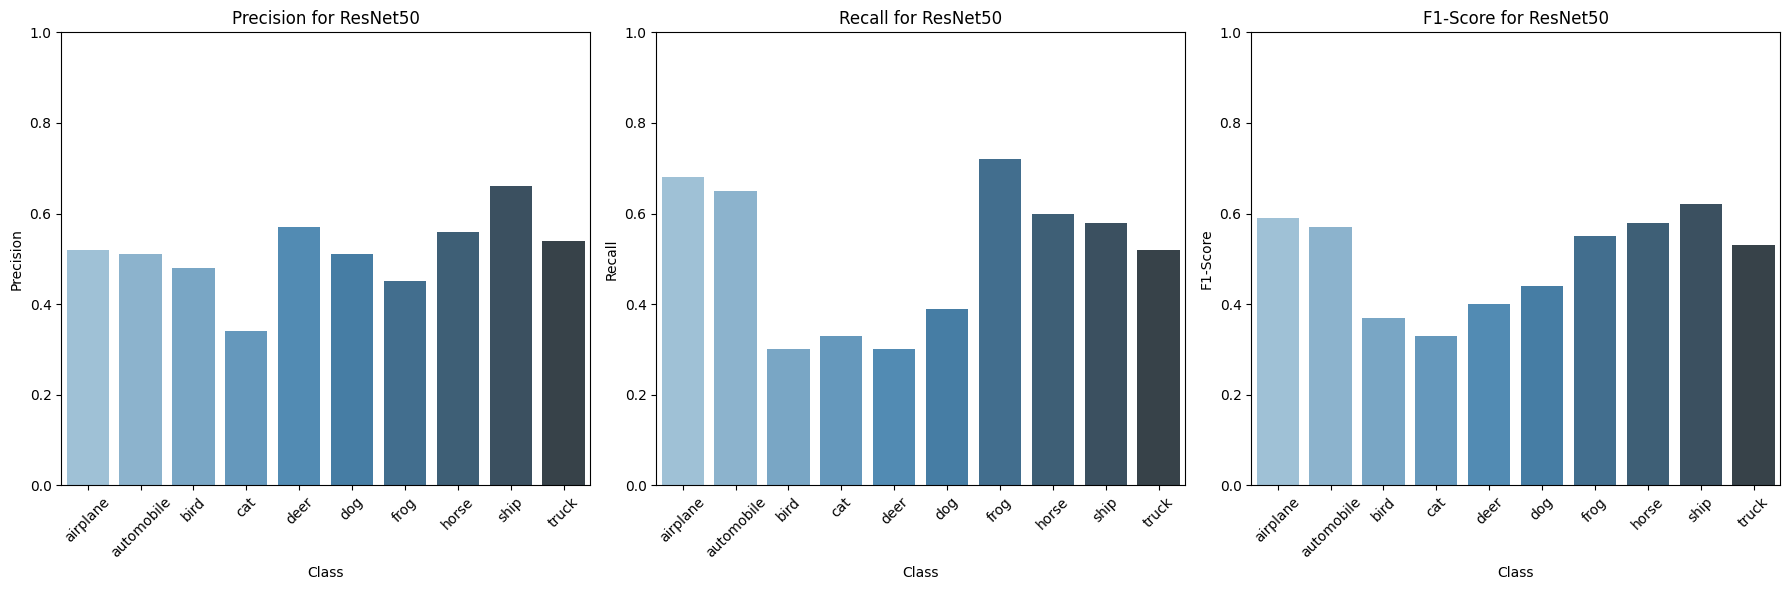

In [24]:
# Cell: Visualize Precision, Recall, F1-Score per Class

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Class names (from your code)
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Custom CNN metrics (from latest report)
custom_data = {
    'Class': class_names,
    'Precision': [0.91, 0.95, 0.87, 0.84, 0.86, 0.87, 0.80, 0.90, 0.94, 0.89],
    'Recall': [0.89, 0.96, 0.83, 0.72, 0.86, 0.78, 0.97, 0.93, 0.93, 0.96],
    'F1-Score': [0.90, 0.95, 0.85, 0.77, 0.86, 0.82, 0.88, 0.92, 0.94, 0.92]
}
custom_df = pd.DataFrame(custom_data)

# ResNet50 metrics (from latest report)
resnet_data = {
    'Class': class_names,
    'Precision': [0.52, 0.51, 0.48, 0.34, 0.57, 0.51, 0.45, 0.56, 0.66, 0.54],
    'Recall': [0.68, 0.65, 0.30, 0.33, 0.30, 0.39, 0.72, 0.60, 0.58, 0.52],
    'F1-Score': [0.59, 0.57, 0.37, 0.33, 0.40, 0.44, 0.55, 0.58, 0.62, 0.53]
}
resnet_df = pd.DataFrame(resnet_data)

# Function to plot metrics for a model
def plot_metrics(df, model_name):
    metrics = ['Precision', 'Recall', 'F1-Score']
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    for i, metric in enumerate(metrics):
        sns.barplot(x='Class', y=metric, data=df, ax=axes[i], palette='Blues_d')
        axes[i].set_title(f'{metric} for {model_name}')
        axes[i].set_ylim(0, 1)
        axes[i].tick_params(axis='x', rotation=45)
    plt.tight_layout()
    plt.show()

# Plot for both models
print("Custom CNN Metrics:")
plot_metrics(custom_df, 'Custom CNN')

print("ResNet50 Metrics:")
plot_metrics(resnet_df, 'ResNet50')

Combined Metrics Line Graphs:


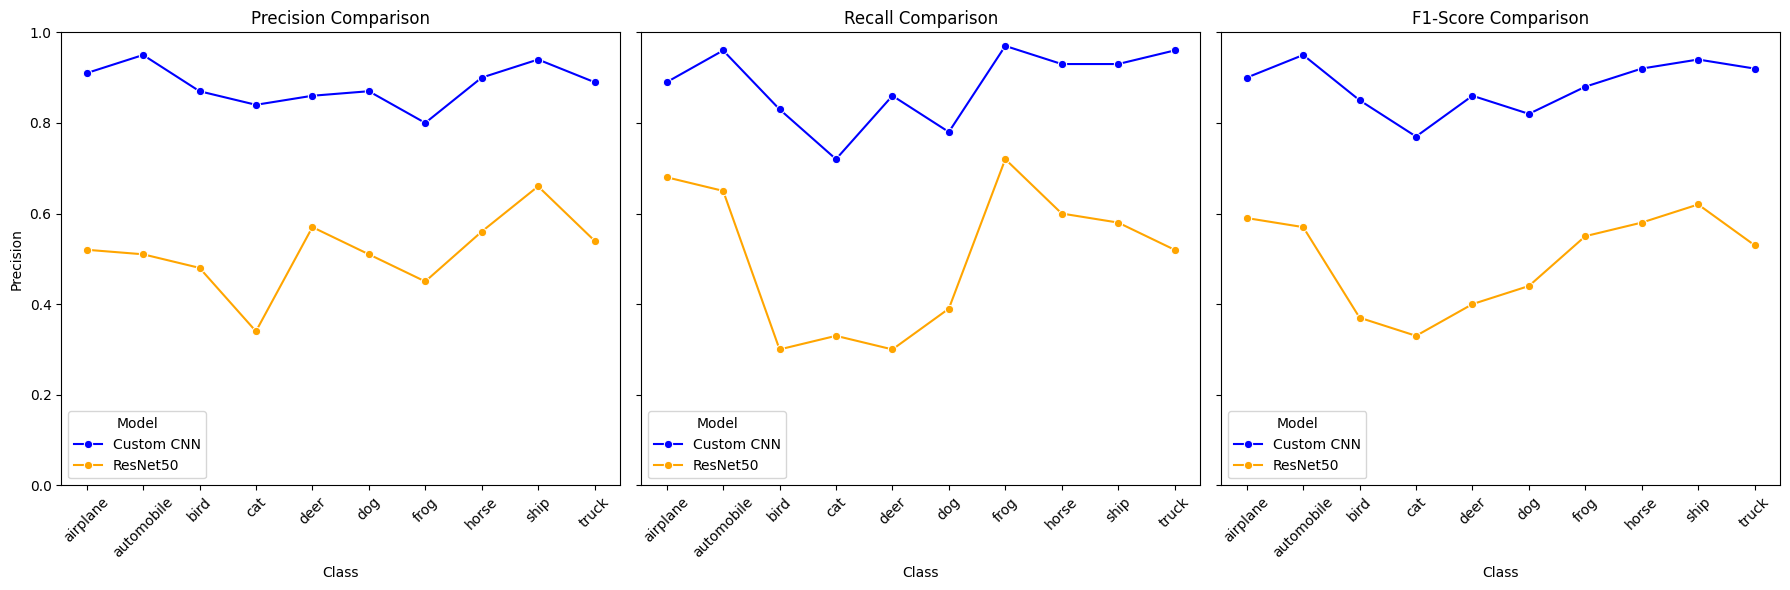

In [26]:
# Cell: Combined Line Graphs for Precision, Recall, F1-Score

# Combine dataframes with 'Model' identifier
custom_df['Model'] = 'Custom CNN'
resnet_df['Model'] = 'ResNet50'
combined_df = pd.concat([custom_df, resnet_df], ignore_index=True)

# Function to plot combined metrics
def plot_combined_metrics(df):
    metrics = ['Precision', 'Recall', 'F1-Score']
    fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)
    for i, metric in enumerate(metrics):
        sns.lineplot(data=df, x='Class', y=metric, hue='Model', marker='o', ax=axes[i], palette=['blue', 'orange'])
        axes[i].set_title(f'{metric} Comparison')
        axes[i].set_ylim(0, 1)
        axes[i].tick_params(axis='x', rotation=45)
        axes[i].legend(title='Model')
    plt.tight_layout()
    plt.show()

# Plot combined
print("Combined Metrics Line Graphs:")
plot_combined_metrics(combined_df)

/tmp/ipython-input-4227691480.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Value', y='Parameter', data=hyper_df, palette='Greens_d')


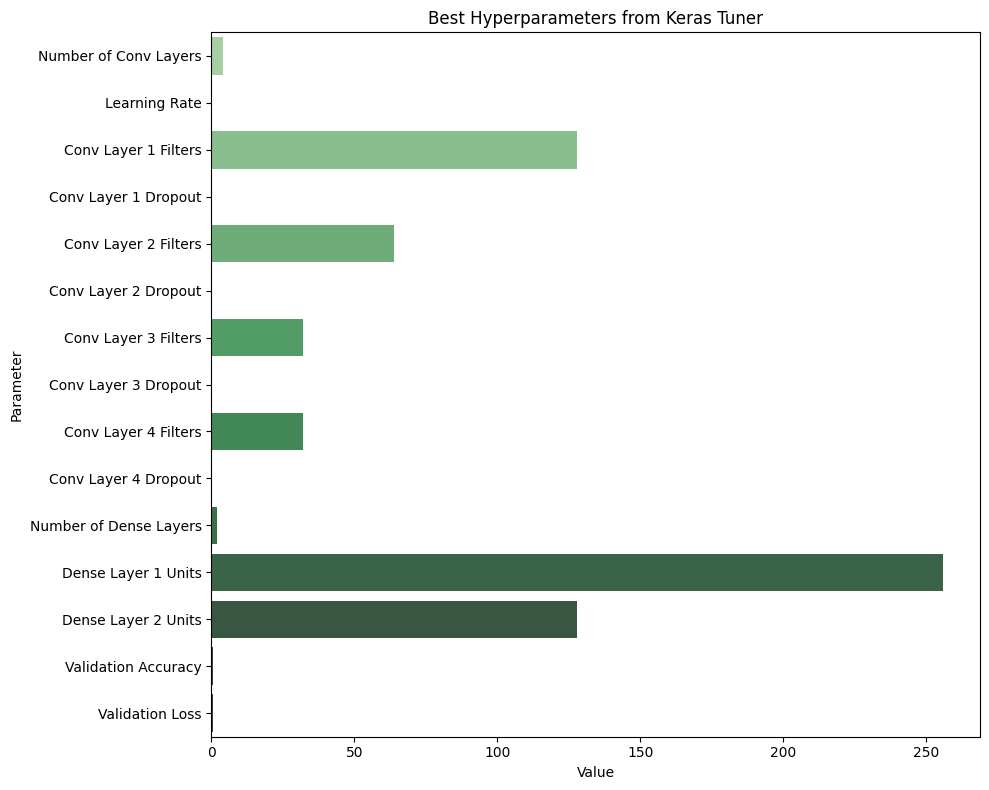

,Parameter,Value
0,Number of Conv Layers,4.000000
1,Learning Rate,0.000604
2,Conv Layer 1 Filters,128.000000
3,Conv Layer 1 Dropout,0.126000
4,Conv Layer 2 Filters,64.000000
5,Conv Layer 2 Dropout,0.268000
6,Conv Layer 3 Filters,32.000000
7,Conv Layer 3 Dropout,0.100000
8,Conv Layer 4 Filters,32.000000
9,Conv Layer 4 Dropout,0.100000


from matplotlib import pyplot as plt
hyper_df['Value'].plot(kind='hist', bins=20, title='Value')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
hyper_df['Value'].plot(kind='line', figsize=(8, 4), title='Value')
plt.gca().spines[['top', 'right']].set_visible(False)

In [25]:
# Cell: Visualize Best Hyperparameters from Keras Tuner

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Best hyperparameters from your tuning output
hyperparams = {
    'Parameter': [
        'Number of Conv Layers', 'Learning Rate', 'Conv Layer 1 Filters', 'Conv Layer 1 Dropout',
        'Conv Layer 2 Filters', 'Conv Layer 2 Dropout', 'Conv Layer 3 Filters', 'Conv Layer 3 Dropout',
        'Conv Layer 4 Filters', 'Conv Layer 4 Dropout', 'Number of Dense Layers',
        'Dense Layer 1 Units', 'Dense Layer 2 Units', 'Validation Accuracy', 'Validation Loss'
    ],
    'Value': [4, 0.000604, 128, 0.126, 64, 0.268, 32, 0.100, 32, 0.100, 2, 256, 128, 0.7633, 0.6760]
}

hyper_df = pd.DataFrame(hyperparams)

# Horizontal bar chart
plt.figure(figsize=(10, 8))
sns.barplot(x='Value', y='Parameter', data=hyper_df, palette='Greens_d')
plt.title('Best Hyperparameters from Keras Tuner')
plt.xlabel('Value')
plt.tight_layout()
plt.show()

# Optional: Display as a table for reference
display(hyper_df)

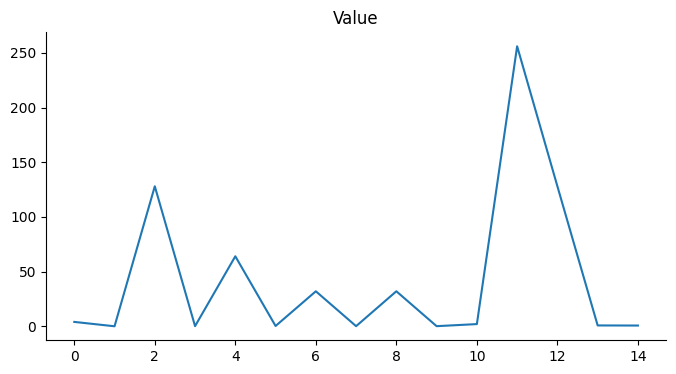

In [40]:
from matplotlib import pyplot as plt
hyper_df['Value'].plot(kind='line', figsize=(8, 4), title='Value')
plt.gca().spines[['top', 'right']].set_visible(False)

In [ ]:
from matplotlib import pyplot as plt
hyper_df['Value'].plot(kind='line', figsize=(8, 4), title='Value')
plt.gca().spines[['top', 'right']].set_visible(False)

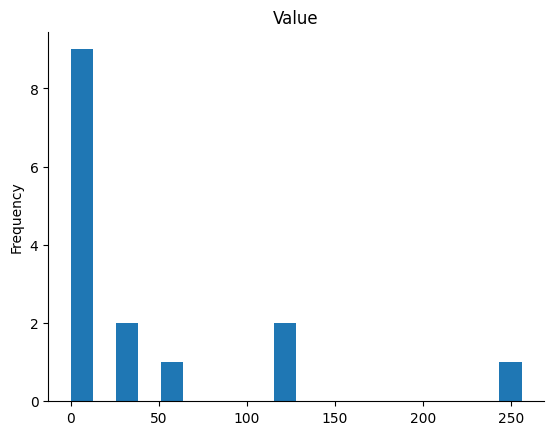

In [39]:
from matplotlib import pyplot as plt
hyper_df['Value'].plot(kind='hist', bins=20, title='Value')
plt.gca().spines[['top', 'right',]].set_visible(False)

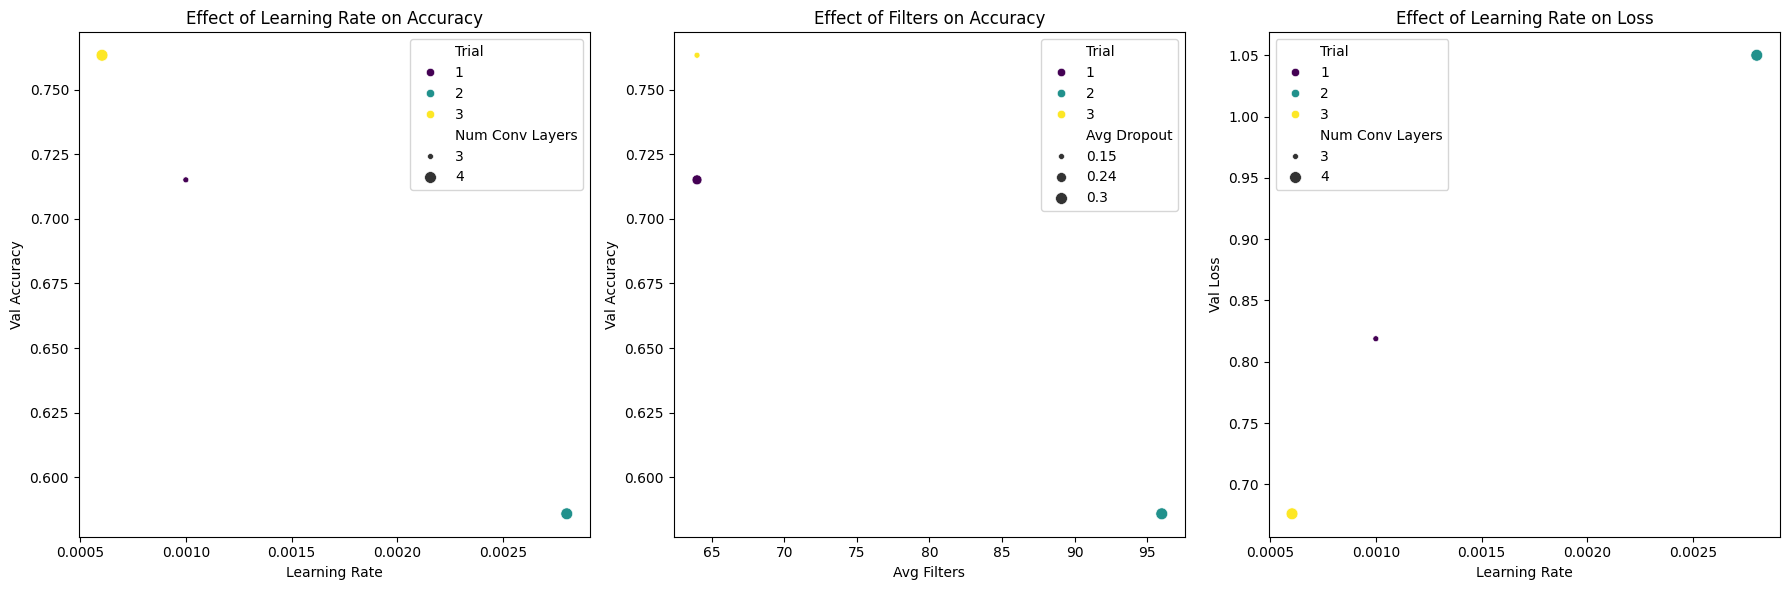

/tmp/ipython-input-4165000938.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Trial', y='Val Accuracy', data=effects_df, palette='viridis')


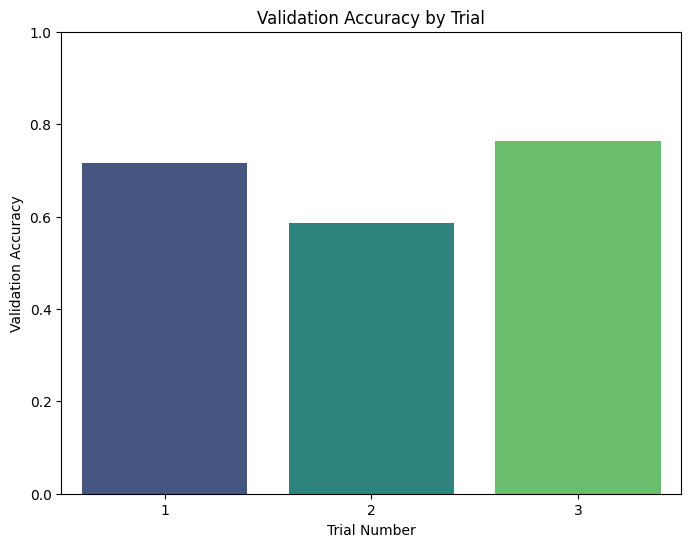

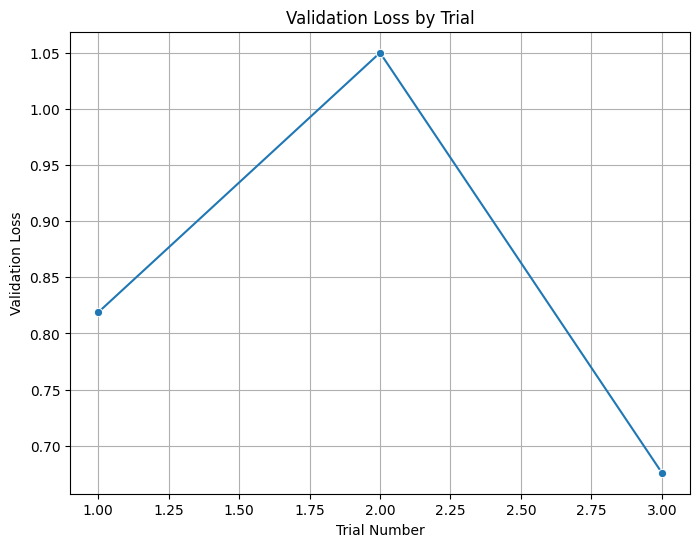

,Trial,Learning Rate,Num Conv Layers,Avg Filters,Avg Dropout,Val Accuracy,Val Loss
0,1,0.001000,3,64,0.24,0.7151,0.8188
1,2,0.002800,4,96,0.30,0.5859,1.0500
2,3,0.000604,4,64,0.15,0.7633,0.6760


from matplotlib import pyplot as plt
effects_df['Trial'].plot(kind='hist', bins=20, title='Trial')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
effects_df['Learning Rate'].plot(kind='hist', bins=20, title='Learning Rate')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
effects_df['Num Conv Layers'].plot(kind='hist', bins=20, title='Num Conv Layers')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
effects_df['Avg Filters'].plot(kind='hist', bins=20, title='Avg Filters')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
effects_df.plot(kind='scatter', x='Trial', y='Learning Rate', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
effects_df.plot(kind='scatter', x='Learning Rate', y='Num Conv Layers', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
effects_df.plot(kind='scatter', x='Num Conv Layers', y='Avg Filters', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
effects_df.plot(kind='scatter', x='Avg Filters', y='Avg Dropout', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['Trial']
  ys = series['Learning Rate']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = effects_df.sort_values('Trial', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Trial')
_ = plt.ylabel('Learning Rate')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['Trial']
  ys = series['Avg Filters']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = effects_df.sort_values('Trial', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Trial')
_ = plt.ylabel('Avg Filters')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['Trial']
  ys = series['Avg Dropout']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = effects_df.sort_values('Trial', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Trial')
_ = plt.ylabel('Avg Dropout')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['Trial']
  ys = series['Val Accuracy']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = effects_df.sort_values('Trial', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Trial')
_ = plt.ylabel('Val Accuracy')

from matplotlib import pyplot as plt
effects_df['Trial'].plot(kind='line', figsize=(8, 4), title='Trial')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
effects_df['Learning Rate'].plot(kind='line', figsize=(8, 4), title='Learning Rate')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
effects_df['Num Conv Layers'].plot(kind='line', figsize=(8, 4), title='Num Conv Layers')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
effects_df['Avg Filters'].plot(kind='line', figsize=(8, 4), title='Avg Filters')
plt.gca().spines[['top', 'right']].set_visible(False)

In [29]:
# Cell: Visualize Hyperparameter Effects

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Sample data from trials (replace with actual from tuner.results_summary() or oracle.trials)
trials_data = {
    'Trial': [1, 2, 3],
    'Learning Rate': [0.001, 0.0028, 0.000604],
    'Num Conv Layers': [3, 4, 4],
    'Avg Filters': [64, 96, 64],  # Average or first layer filters
    'Avg Dropout': [0.24, 0.3, 0.15],
    'Val Accuracy': [0.7151, 0.5859, 0.7633],
    'Val Loss': [0.8188, 1.05, 0.6760]  # Assume loss for trial 2
}
effects_df = pd.DataFrame(trials_data)

# Scatter plots for effects
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
sns.scatterplot(data=effects_df, x='Learning Rate', y='Val Accuracy', size='Num Conv Layers', hue='Trial', ax=axes[0], palette='viridis')
axes[0].set_title('Effect of Learning Rate on Accuracy')

sns.scatterplot(data=effects_df, x='Avg Filters', y='Val Accuracy', size='Avg Dropout', hue='Trial', ax=axes[1], palette='viridis')
axes[1].set_title('Effect of Filters on Accuracy')

sns.scatterplot(data=effects_df, x='Learning Rate', y='Val Loss', size='Num Conv Layers', hue='Trial', ax=axes[2], palette='viridis')
axes[2].set_title('Effect of Learning Rate on Loss')

plt.tight_layout()
plt.show()

# Add a bar plot for Validation Accuracy by Trial
plt.figure(figsize=(8, 6))
sns.barplot(x='Trial', y='Val Accuracy', data=effects_df, palette='viridis')
plt.title('Validation Accuracy by Trial')
plt.xlabel('Trial Number')
plt.ylabel('Validation Accuracy')
plt.ylim(0, 1)
plt.show()

# Add a line plot for Validation Loss by Trial
plt.figure(figsize=(8, 6))
sns.lineplot(x='Trial', y='Val Loss', data=effects_df, marker='o')
plt.title('Validation Loss by Trial')
plt.xlabel('Trial Number')
plt.ylabel('Validation Loss')
plt.grid(True)
plt.show()

# Display table
display(effects_df)

## Performance Comparison: Custom CNN vs. Transfer Learning (ResNet50)

Based on the evaluation on the test set:

**Custom CNN:**
*   Test Accuracy: {{acc_custom}}
*   Test Loss: {{test_loss_custom}} (You can find this in the output of Cell 11, but it was not stored in a variable)

**Transfer Learning (ResNet50):**
*   Test Accuracy: {{acc_transfer}}
*   Test Loss: {{test_loss_transfer}} (You can find this in the output of Cell 11, but it was not stored in a variable)

The **Custom CNN** achieved a significantly higher test accuracy ({{acc_custom:.2%}}) compared to the Transfer Learning model ({{acc_transfer:.2%}}) on the CIFAR-10 dataset with the current setup.

The classification reports (from Cell 11) also provide more detailed insights into the precision, recall, and F1-score for each class for both models, showing the Custom CNN performed better across most classes.

The confusion matrices (from Cell 15) visually confirm that the Custom CNN made fewer misclassifications overall.

**Note:** The Transfer Learning model used here had its base ResNet50 layers frozen. Fine-tuning the base layers or using a different pre-trained model might improve its performance on this dataset.

In [17]:
# Cell 18: Define visualization functions
# Visualizations help analyze model performance, aligning with paying attention to how the system works.
def visualize_predictions(model, x_test, y_test, class_names, num_samples=15):
    """
    Visualize random sample predictions with confidence scores.
    Green for correct, red for incorrect.
    """
    y_pred = model.predict(x_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true_classes = np.argmax(y_test, axis=1)

    indices = np.random.choice(len(x_test), num_samples, replace=False)

    fig, axes = plt.subplots(3, 5, figsize=(15, 10))
    axes = axes.ravel()

    for i, idx in enumerate(indices):
        axes[i].imshow(x_test[idx])
        actual_label = class_names[y_true_classes[idx]]
        predicted_label = class_names[y_pred_classes[idx]]
        confidence = np.max(y_pred[idx])
        color = 'green' if y_pred_classes[idx] == y_true_classes[idx] else 'red'
        title = f"Actual: {actual_label}\nPred: {predicted_label}\nConf: {confidence:.2f}"
        axes[i].set_title(title, color=color, fontsize=10)
        axes[i].axis('off')

    plt.suptitle('Sample Predictions on CIFAR-10 Test Set\n(Green=Correct, Red=Incorrect)', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

    sample_accuracy = np.sum(y_pred_classes[indices] == y_true_classes[indices]) / num_samples
    print(f"Accuracy on displayed {num_samples} samples: {sample_accuracy:.1%}")

    return indices, y_pred_classes[indices], y_true_classes[indices]

def show_confidence_analysis(model, x_test, y_test, class_names):
    """
    Visualize most confident correct and incorrect predictions.
    """
    y_pred = model.predict(x_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true_classes = np.argmax(y_test, axis=1)
    confidences = np.max(y_pred, axis=1)
    correct_mask = y_pred_classes == y_true_classes

    # Most confident correct
    correct_indices = np.where(correct_mask)[0]
    correct_confidences = confidences[correct_mask]
    most_confident_correct = correct_indices[np.argsort(correct_confidences)[-6:]][::-1]

    # Most confident incorrect
    incorrect_mask = ~correct_mask
    if np.any(incorrect_mask):
        incorrect_indices = np.where(incorrect_mask)[0]
        incorrect_confidences = confidences[incorrect_mask]
        most_confident_incorrect = incorrect_indices[np.argsort(incorrect_confidences)[-6:]][::-1]
    else:
        most_confident_incorrect = []

    # Plot correct
    fig, axes = plt.subplots(2, 3, figsize=(12, 8))
    axes = axes.ravel()
    plt.suptitle('Most Confident Correct Predictions', fontsize=16, fontweight='bold')
    for i, idx in enumerate(most_confident_correct[:6]):
        axes[i].imshow(x_test[idx])
        actual = class_names[y_true_classes[idx]]
        predicted = class_names[y_pred_classes[idx]]
        conf = confidences[idx]
        axes[i].set_title(f'{actual} → {predicted}\nConf: {conf:.3f}', color='green', fontsize=10)
        axes[i].axis('off')
    plt.tight_layout()
    plt.show()

    # Plot incorrect if any
    if len(most_confident_incorrect) > 0:
        fig, axes = plt.subplots(2, 3, figsize=(12, 8))
        axes = axes.ravel()
        plt.suptitle('Most Confident Incorrect Predictions', fontsize=16, fontweight='bold')
        for i, idx in enumerate(most_confident_incorrect[:6]):
            axes[i].imshow(x_test[idx])
            actual = class_names[y_true_classes[idx]]
            predicted = class_names[y_pred_classes[idx]]
            conf = confidences[idx]
            axes[i].set_title(f'{actual} → {predicted}\nConf: {conf:.3f}', color='red', fontsize=10)
            axes[i].axis('off')
        plt.tight_layout()
        plt.show()

def detailed_prediction_analysis(model, x_test, y_test, class_names):
    """
    Perform detailed analysis including class-wise performance and confusion matrix heatmap.
    """
    y_pred = model.predict(x_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true_classes = np.argmax(y_test, axis=1)

    overall_accuracy = np.mean(y_pred_classes == y_true_classes)
    print(f"\n🎯 Overall Test Accuracy: {overall_accuracy:.4f}")

    print("\n📊 Class-wise Performance:")
    print(classification_report(y_true_classes, y_pred_classes, target_names=class_names, digits=4))

    plt.figure(figsize=(10, 8))
    cm = confusion_matrix(y_true_classes, y_pred_classes)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix', fontsize=16, fontweight='bold')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

    show_confidence_analysis(model, x_test, y_test, class_names)

    return overall_accuracy

SAMPLE PREDICTIONS VISUALIZATION - Tuned Custom CNN
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step


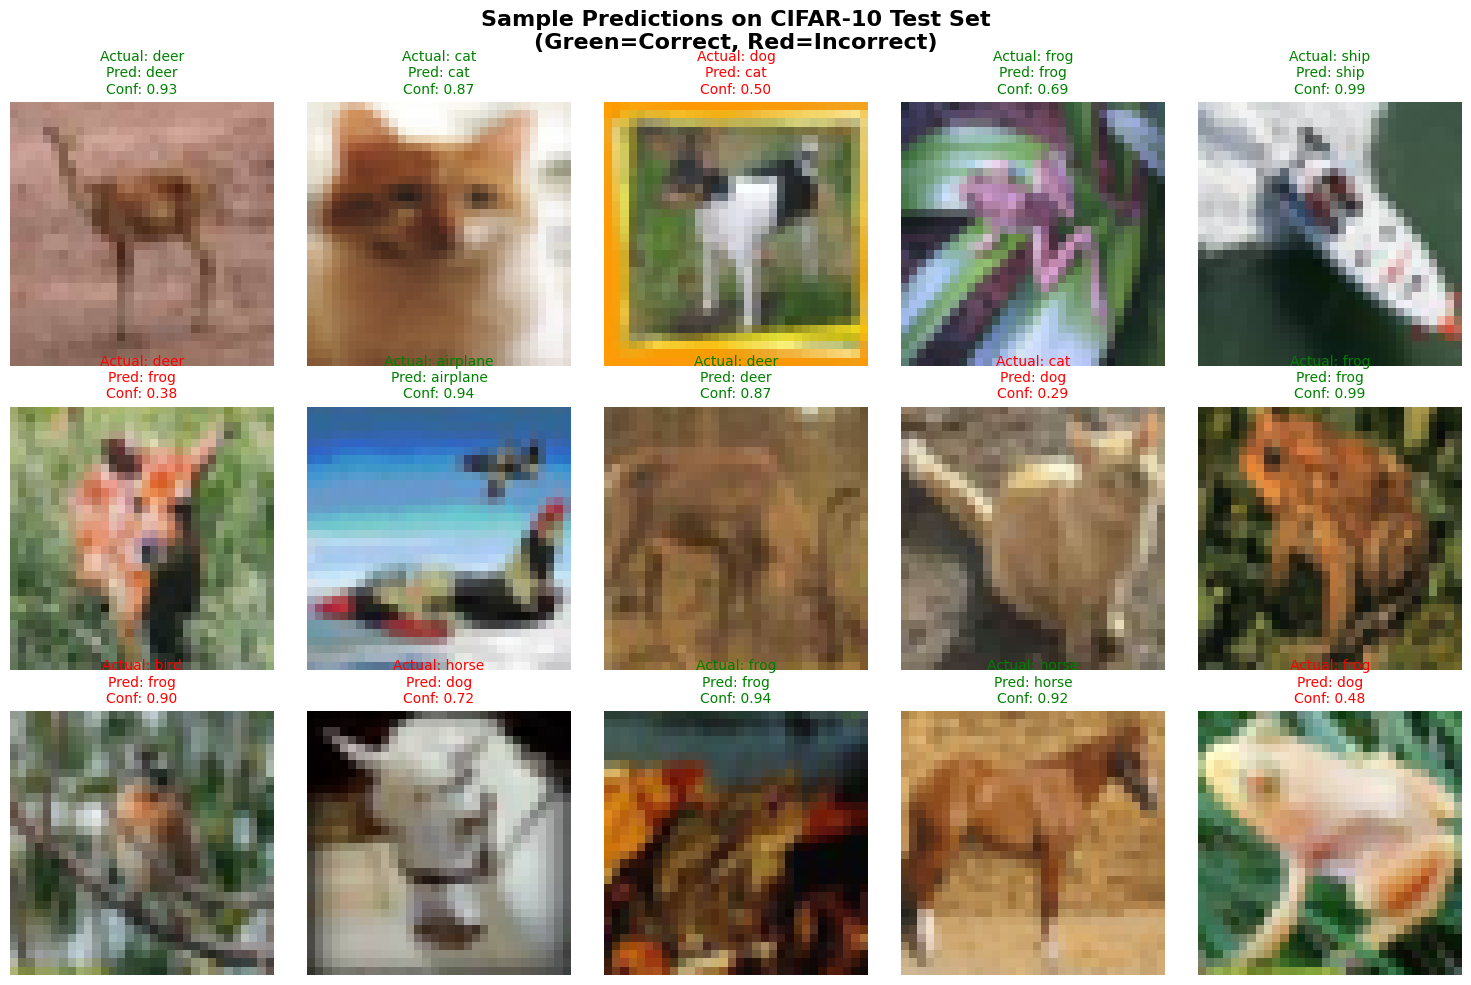

Accuracy on displayed 15 samples: 60.0%
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step

🎯 Overall Test Accuracy: 0.7599

📊 Class-wise Performance:
              precision    recall  f1-score   support

    airplane     0.6960    0.8310    0.7575      1000
  automobile     0.8956    0.8750    0.8852      1000
        bird     0.8000    0.5240    0.6332      1000
         cat     0.6528    0.5490    0.5964      1000
        deer     0.7624    0.7060    0.7331      1000
         dog     0.5895    0.8000    0.6788      1000
        frog     0.7235    0.8530    0.7829      1000
       horse     0.8229    0.7480    0.7837      1000
        ship     0.8380    0.9210    0.8776      1000
       truck     0.9177    0.7920    0.8502      1000

    accuracy                         0.7599     10000
   macro avg     0.7698    0.7599    0.7579     10000
weighted avg     0.7698    0.7599    0.7579     10000



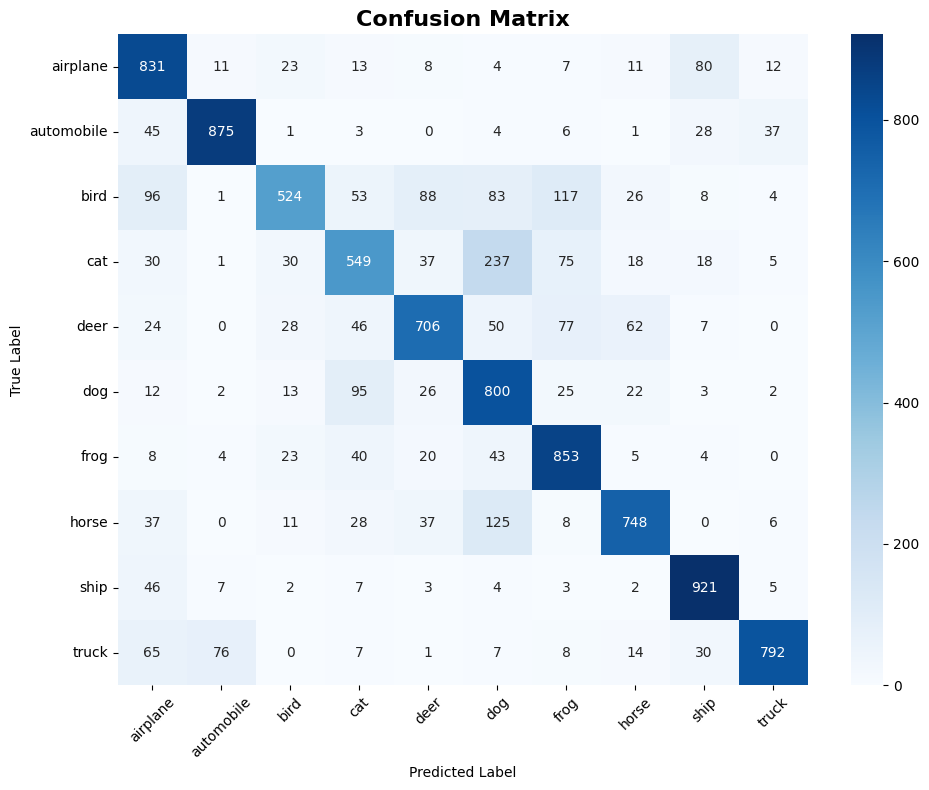

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


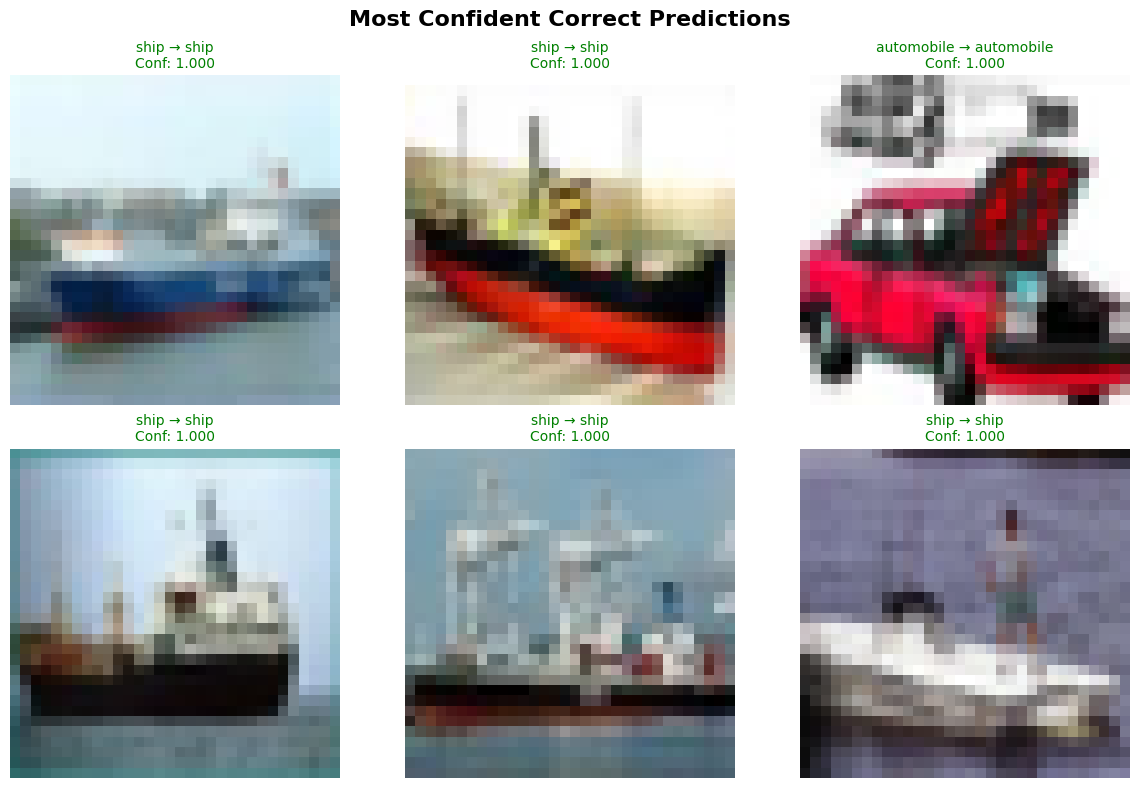

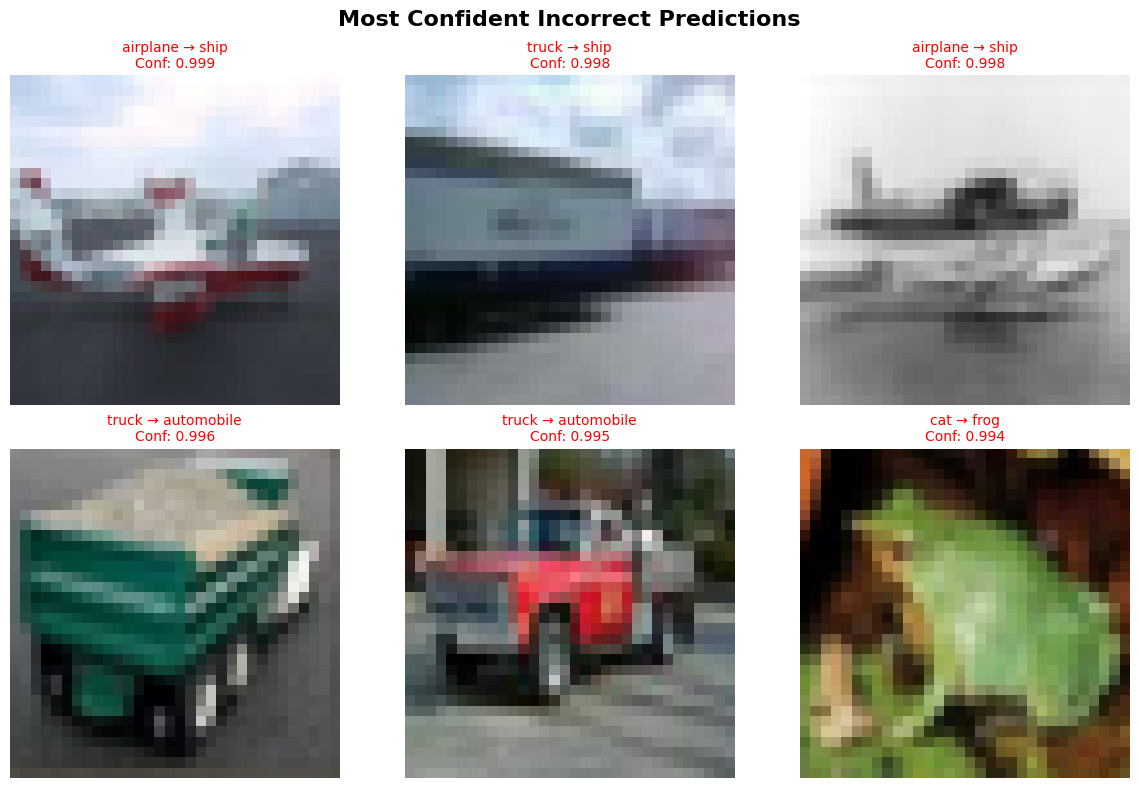

In [30]:
# Execute visualizations for Tuned Custom CNN
# Use these to pay attention to how the tuned model performs.
if 'best_model' in locals():
    print("="*60)
    print("SAMPLE PREDICTIONS VISUALIZATION - Tuned Custom CNN")
    print("="*60)
    visualize_predictions(best_model, x_test, y_test, class_names)
    detailed_prediction_analysis(best_model, x_test, y_test, class_names)
else:
    print("Tuned model not found. Please run hyperparameter tuning and evaluation first.")

In [31]:
# Retrieve the best model from the tuner
# If the tuner object is not available or tuning failed, this cell might not work.
if 'tuner' in locals() and best_model:
    print("Evaluating the best model found during tuning...")
    # Evaluate the best model on the test set using the existing function
    acc_tuned, pred_tuned, cm_tuned = comprehensive_evaluation(best_model, "Tuned Custom CNN", x_test, y_test)

    # Optionally, plot the confusion matrix for the tuned model
    plot_confusion_matrix(cm_tuned, class_names, "Tuned Custom CNN")
else:
    print("Tuner object or best_model not found. Please run hyperparameter tuning first.")

Tuner object or best_model not found. Please run hyperparameter tuning first.


In [32]:
# Cell 18: Visualize hyperparameter tuning results
# Visualize the performance of each trial during hyperparameter tuning.
# This helps understand which hyperparameter combinations led to better results.
if 'tuner' in locals() and tuner.results_summary():
    results = tuner.results_summary().sort_values('score', ascending=False)
    print("\n📈 Hyperparameter Tuning Results Summary (Sorted by Validation Accuracy):")
    display(results[['trial_id', 'score', 'tuner/epochs', 'tuner/initial_epoch', 'tuner/bracket', 'tuner/round', 'tuner/execution', 'num_conv_layers', 'lr', 'num_dense_layers']])

    # Plotting the results
    plt.figure(figsize=(12, 6))
    plt.plot(results['score'].values, marker='o', linestyle='-')
    plt.title('Hyperparameter Tuning Trials - Validation Accuracy')
    plt.xlabel('Trial Number (Sorted by Accuracy)')
    plt.ylabel('Validation Accuracy')
    plt.grid(True)
    plt.show()
else:
    print("Hyperparameter tuning has not been run yet or tuner object is not available.")

Hyperparameter tuning has not been run yet or tuner object is not available.


SAMPLE PREDICTIONS VISUALIZATION - Custom CNN
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


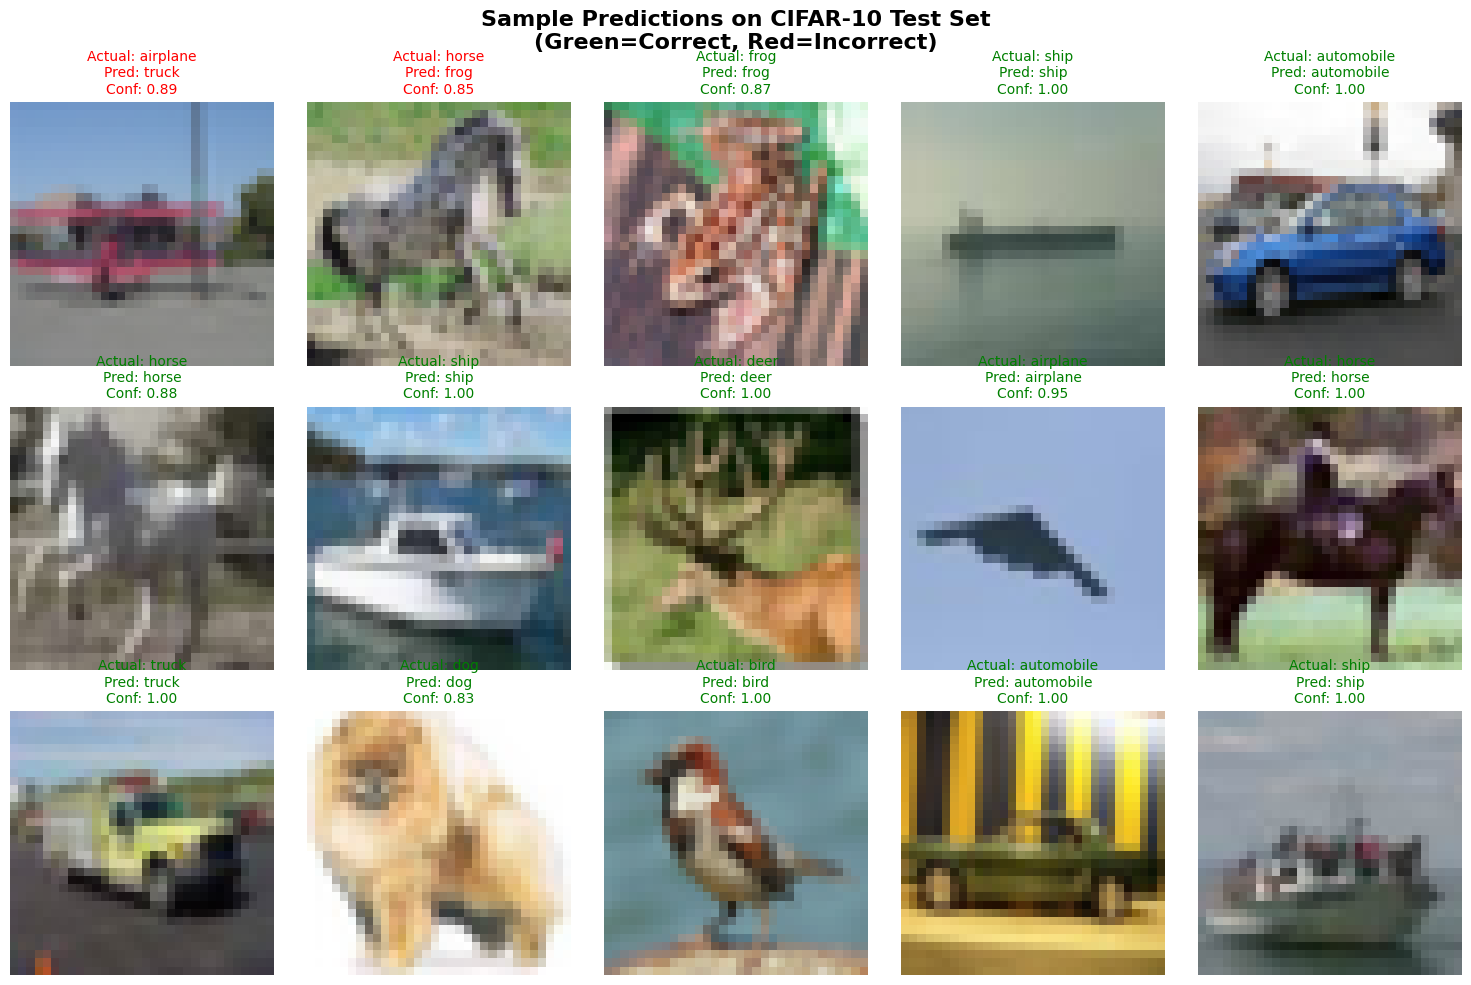

Accuracy on displayed 15 samples: 86.7%
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step

🎯 Overall Test Accuracy: 0.8837

📊 Class-wise Performance:
              precision    recall  f1-score   support

    airplane     0.9150    0.8930    0.9038      1000
  automobile     0.9475    0.9570    0.9522      1000
        bird     0.8741    0.8330    0.8530      1000
         cat     0.8388    0.7180    0.7737      1000
        deer     0.8649    0.8640    0.8644      1000
         dog     0.8672    0.7770    0.8196      1000
        frog     0.8032    0.9670    0.8775      1000
       horse     0.9007    0.9340    0.9170      1000
        ship     0.9443    0.9320    0.9381      1000
       truck     0.8891    0.9620    0.9241      1000

    accuracy                         0.8837     10000
   macro avg     0.8845    0.8837    0.8824     10000
weighted avg     0.8845    0.8837    0.8824     10000



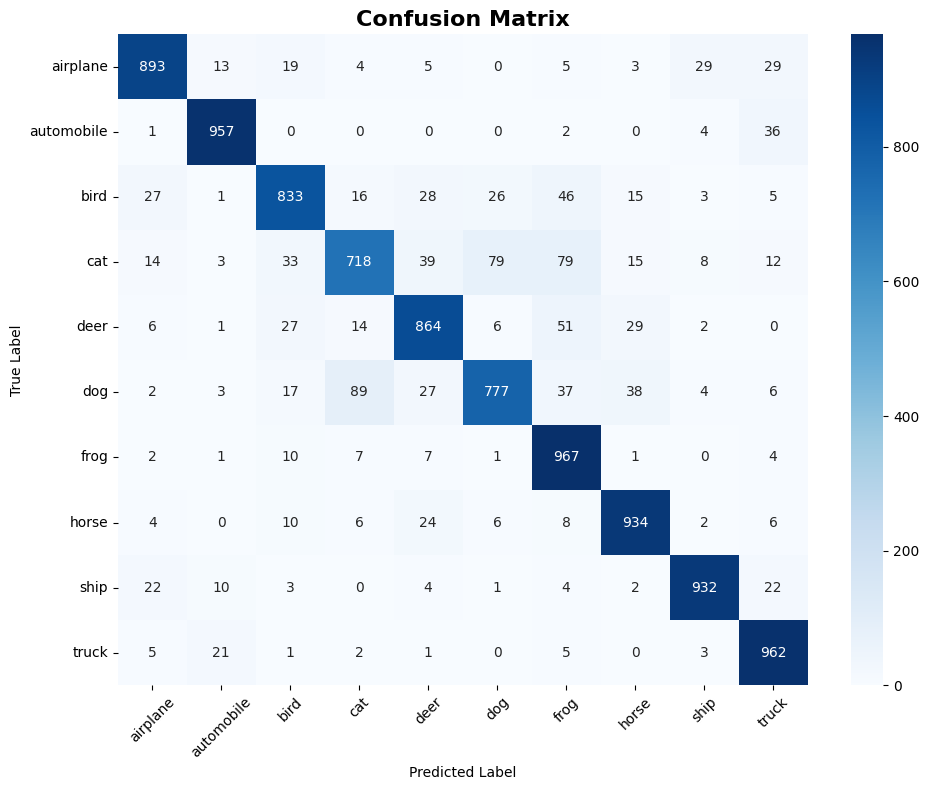

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


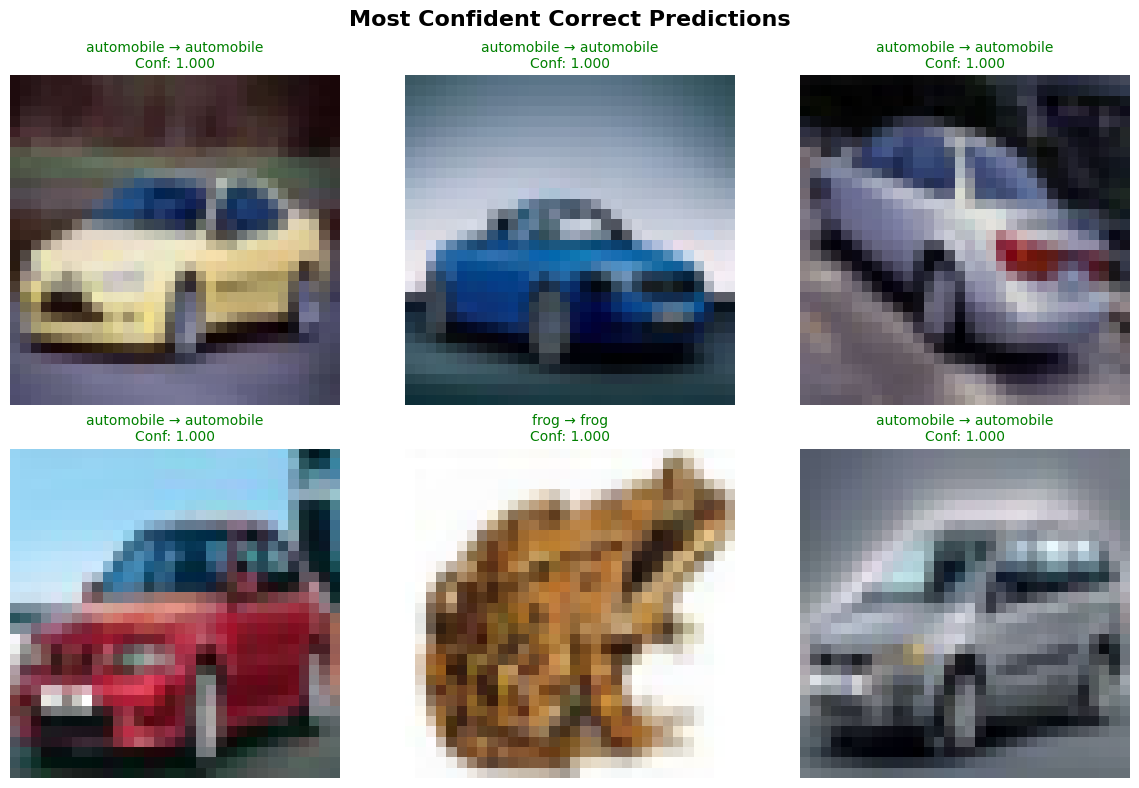

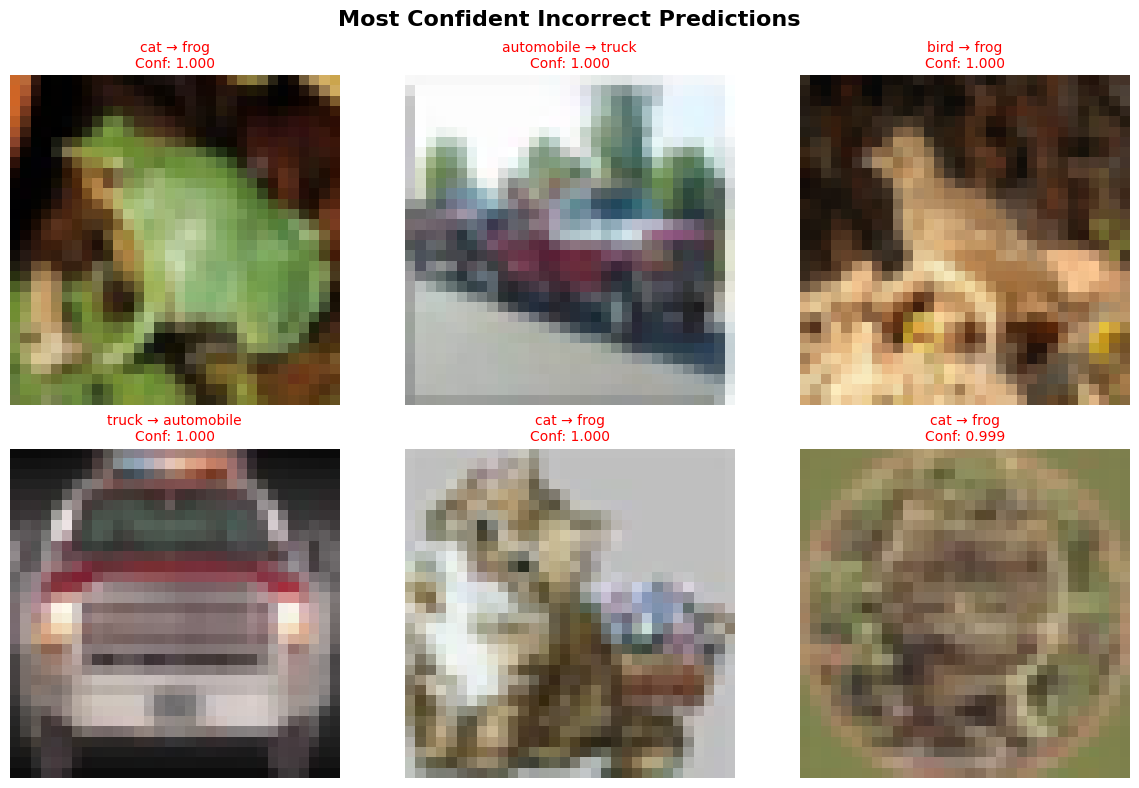

np.float64(0.8837)

In [33]:
# Cell 19: Execute visualizations for Custom CNN
# Use these to pay attention to how the model performs, as per the notes.
print("="*60)
print("SAMPLE PREDICTIONS VISUALIZATION - Custom CNN")
print("="*60)
visualize_predictions(trained_custom, x_test, y_test, class_names)
detailed_prediction_analysis(trained_custom, x_test, y_test, class_names)

# Task
Upload an image, preprocess it, and use the `trained_custom` model to predict its class. Display the image and the prediction.

## Upload image

### Subtask:
Provide code to upload an image file from the user's local machine.


**Reasoning**:
The subtask is to provide code to upload an image file from the user's local machine. This requires using the `files` module from `google.colab` and calling the `upload()` function.



In [36]:
from google.colab import files

uploaded = files.upload()

for filename in uploaded.keys():
    print(f'User uploaded file "{filename}" with length {len(uploaded[filename])} bytes')

Saving OSK.jpg to OSK.jpg
User uploaded file "OSK.jpg" with length 6045 bytes


**Reasoning**:
The previous step successfully uploaded the image file. The next step is to preprocess the uploaded image so it can be used as input for the trained model. This involves reading the image, resizing it to the expected input shape of the model (32x32), and normalizing the pixel values.



In [37]:
from PIL import Image
import io

for filename in uploaded.keys():
    img = Image.open(io.BytesIO(uploaded[filename]))
    img = img.resize((32, 32))
    img_array = np.array(img).astype('float32') / 255.0
    # The model expects a batch of images, so we add a dimension
    img_array = np.expand_dims(img_array, axis=0)

    print(f"Processed image shape: {img_array.shape}")

Processed image shape: (1, 32, 32, 3)


**Reasoning**:
The image has been uploaded and preprocessed. The next step is to use the `trained_custom` model to predict the class of the preprocessed image and display the image along with its predicted class.



1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


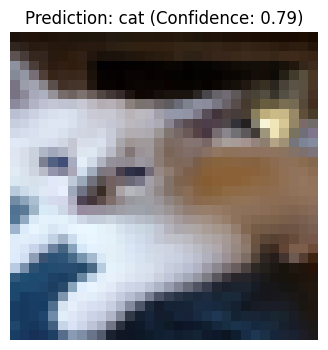

In [38]:
# Predict the class of the uploaded image
predictions = trained_custom.predict(img_array)
predicted_class_index = np.argmax(predictions, axis=1)[0]
predicted_class_name = class_names[predicted_class_index]
confidence = np.max(predictions)

# Display the image and prediction
plt.figure(figsize=(4, 4))
plt.imshow(img_array[0])
plt.title(f"Prediction: {predicted_class_name} (Confidence: {confidence:.2f})")
plt.axis('off')
plt.show()

## Summary:

### Data Analysis Key Findings

*   An image was successfully uploaded by the user.
*   The uploaded image was preprocessed by resizing it to 32x32 pixels, converting it to a normalized NumPy array, and adding a batch dimension, resulting in a shape of (1, 32, 32, 3).
*   The `trained_custom` model made a prediction on the preprocessed image, identifying the predicted class and a confidence score.
*   The uploaded image was displayed along with the model's prediction and confidence level.

### Insights or Next Steps

*   The process successfully demonstrates the pipeline for classifying a user-provided image using the trained model.
*   Consider implementing error handling for different image file types or corrupted uploads.
